In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
from sklearn import datasets, linear_model
import datetime
import time
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings(action='ignore')
Working_dir = os.getcwd()
plt.rc('font', family='serif', serif='Times New Roman', size = '10' )

In [2]:
import sys
print(sys.version)

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


In [2]:
zabbix_df = pd.read_excel( os.path.join( Working_dir, "zabbix_v3_py.xlsx" ) )
lsf_df = pd.read_excel( os.path.join( Working_dir, "lsf_v3_short_and_long_jobs_sorted_py.xlsx" ) )
# lsf_df_v3 = pd.read_excel( os.path.join( Working_dir, "lsf_v3_py.xlsx" ) )

In [3]:
zabbix_df.shape, lsf_df.shape

((8763, 11), (530668, 19))

In [4]:
zabbix_df.columns.values

array(['Start_Timestamp (1h interval)', 'min_power', 'avg_power',
       'max_power', 'measure time in seconds', 'date_py', 'time_py',
       'timestamp_py', 'energy_avg (kWh)', 'energy_min (kWh)',
       'energy_max (kWh)'], dtype=object)

In [5]:
lsf_df.columns.values

array(['row_counter', 'job_id', 'number_of_cores_used', 'user_name',
       'queue_len_hours', 'queue_name', 'directory_of_running_executable',
       'name_of_executable', 'job_status', 'start_unixtime',
       'stop_unixtime', 'job_duration_sec', 'queue_duration_sec',
       'percentage_of_usage_of_queue', 'residual_time_of_queue',
       'application_performed_and_scope', 'start_timestamp_py',
       'stop_timestamp_py', 'executable_full_name'], dtype=object)

### Extract data for 19, February, 2017, 12:00 - 19, March, 2017, 12:00 and so on each month

In [9]:
print('The earliest timestamp in each table')
print('zabbix: \t', zabbix_df.timestamp_py.min(), '\nlsf: \t\t', datetime.datetime.utcfromtimestamp(lsf_df['start_unixtime'].min()),'\n') 

print('The latest timestamp in each table')
print('zabbix: \t', zabbix_df.timestamp_py.max(), '\nlsf: \t\t',datetime.datetime.utcfromtimestamp(lsf_df['stop_unixtime'].max())) 

The earliest timestamp in each table
zabbix: 	 2017-02-19 12:00:00 
lsf: 		 2016-11-11 17:38:05 

The latest timestamp in each table
zabbix: 	 2018-02-19 14:00:00 
lsf: 		 2018-01-25 04:12:17


---
### Jobs running time
min, max, avg

In [6]:
print(lsf_df.job_duration_sec.min(), lsf_df.job_duration_sec.max()/3600, np.mean(lsf_df.job_duration_sec.as_matrix())/3600.)

2.0 220.756666667 1.9695446944


---
Functions

In [2]:
def write_to_excel ( table, path ):
    excel_writer = pd.ExcelWriter( path )
    table.to_excel(excel_writer)
    excel_writer.save()

In [3]:
def lsf_one_month( lsf_df, zabbix_df, start_moment, end_moment, folder_name ):
    lsf_month_df = pd.DataFrame(columns = lsf_df.columns.values)
    
    lsf_month_df = lsf_df[((lsf_df.start_timestamp_py >= start_moment)   & (lsf_df.stop_timestamp_py <= end_moment) \
       | (lsf_df.start_timestamp_py <= start_moment) & (lsf_df.stop_timestamp_py >= start_moment) \
       | (lsf_df.start_timestamp_py <= end_moment  ) & (lsf_df.stop_timestamp_py  >= end_moment) \
       | (lsf_df.start_timestamp_py <= start_moment) & (lsf_df.stop_timestamp_py  >= end_moment))].copy()
        
    write_to_excel( lsf_month_df, os.path.join( folder_name, 'lsf_month_py.xlsx') )
    
    return lsf_month_df

In [4]:
def zabbix_one_month( lsf_df, zabbix_df, start_datetime, end_datetime, folder_name ):

    zabbix_month_df = pd.DataFrame(columns = zabbix_df.columns.values)
    
    zabbix_month_df = zabbix_df[((zabbix_df.timestamp_py >= start_datetime) & \
                                 (zabbix_df.timestamp_py < end_datetime))].copy()
    
    return zabbix_month_df

In [5]:
# creating a table:
#   | job_name_1 | job_name_2 | ...
# ----------------------------------
# h1|    w_11    |    w_12    |...
# ----------------------------------
# h2|    w_21    |    w_22    |...
# ...
# ----------------------------------

# where w_ij = (duration of job i in sec duing hour j) / 3600 * (number of cores required for job i completion)

def process_matrix_one_month ( zabbix_month_df, lsf_month_df, folder_name, job_status='any', category='process' ):
    job_status_list = ['any', 'exit', 'done', \
                       'exit_long', 'done_long', \
                       'exit_short_30_sec',\
                       'done_only',\
                       'exit_only'
                      ]
    if job_status not in job_status_list:
        raise ValueError("Invalid job status. Expected one of: %s" % job_status_list)
        
    category_list = ['process', 'queue', 'parallel_serial']
    if category not in category_list:
        raise ValueError("Invalid use of category. Expected one of: %s" % category_list)

    if 'process' == category:
        category_name = 'executable_full_name'
    elif 'queue' == category:
        category_name = 'queue_name'
    else:
        category_name = 'parallel_serial'
        
    proc_df = pd.DataFrame(columns = lsf_month_df[category_name].unique(), index=zabbix_month_df.timestamp_py)

    min_time = zabbix_month_df.timestamp_py.iloc[0]
    max_time = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1] + datetime.timedelta(minutes = 59, seconds = 59)
    max_cores = lsf_month_df['number_of_cores_used'].max()

    proc_df[:] = 0 
    i=0
    # iterate over jobs in lsf
    for index, line in lsf_month_df.iterrows():
        #i-line index
        i+=1
        line_job_status = line.job_status.lower()
        if ( job_status=='any' or line_job_status==job_status \
           or ( job_status == 'exit' and (line_job_status in ['exit_long', 'exit_short_30_sec', 'exit'] ) ) \
            or (job_status == 'done' and (line_job_status in ['done', 'done_long'] ) ) \
            or (job_status == 'done_only' and (line_job_status in ['done'] ) ) \
            or (job_status == 'exit_only' and (line_job_status in ['exit', 'done_long', 'exit_long',\
                                                                   'exit_short_30_sec']) ) ):
            cat_name = line[category_name]
            cores = line['number_of_cores_used']
            # start and end time in full date format 
            start_time = line.start_timestamp_py
            end_time = line.stop_timestamp_py

            # t is our current position
            t = start_time
            # process length
            length = end_time - start_time + datetime.timedelta(seconds=1)
            # if a proces began before the first timestamp in zabbix
            # decrease length and step onto the first timestamp in zabbix
            if ( min_time > start_time ):
                t = min_time
                length -= min_time - start_time
            # while current position is not at the end time of a process or end of table
            while t <= end_time and t <= max_time:
                # find row name in table = even hour and next row name
                start_in_table = t
                start_in_table = start_in_table.replace(minute=0, second=0)
                next_in_table = start_in_table + datetime.timedelta(hours=1)

                # if a process ends within this hour write its weight 
                # and put current position far to the right
                if ( t + length < next_in_table ):
                    proc_df.loc[start_in_table,cat_name] += (length.total_seconds()/3600)*(cores)#/max_cores)
                    t = next_in_table
                else:
                    # if a process lasts longer than the current hour range
                    # add number of seconds which it runs during this hour
                    # decrease length of the process by the same mount
                    # write its weight to the matrix
                    to_add = next_in_table - t
                    length -= to_add

                    proc_df.loc[start_in_table,cat_name] += (to_add.total_seconds()/3600)*(cores)#/max_cores)
                    t += to_add
            
    print('Proc matrix finished\n')
    return proc_df

In [6]:
def divide ( a, b ):
    c = np.zeros_like(a)
    for i in range(len(a)):
        if ( 0 != b[i] ):
            c[i] = a[i]/b[i]
        else:
            c[i] = None
    return c

In [7]:
def outliers_to_zero(x):
    final_list = x.copy()
    outliers_indices = x[(x - x.median()) > 2 * (x.quantile(.75)-x.quantile(0.25))].index
    final_list.loc[outliers_indices] = 0
    return final_list, outliers_indices

------
### Extracting each consecutive month

In [9]:
lsf_df_in_case = lsf_df.copy()

In [10]:
# lsf_df=lsf_df_in_case.copy()

In [12]:
# x - int array[11] of mean energy usage for each month 
# zero_sum - lines from global zabbix 
# where sum of weights from proc_matrix over row are zero
# used to check idle energy use

x = []
zero_sum = pd.DataFrame(columns = zabbix_df.columns.values)

In [38]:
left_time_border = datetime.datetime(2017,2,19,12,0)
right_time_border = datetime.datetime(2017,3,19,12,0)

# left_time_border = datetime.datetime(2017,12,19,12,0)
# # date_new = lsf_df.stop_timestamp_py.max().date()
# date_new = datetime.date(year=2018, month=1, day=25)
# right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1
while ( right_time_border <= \
       datetime.datetime.combine(lsf_df.stop_timestamp_py.max().date(), \
                                 right_time_border.time())):
    # for each month create a folder
    folder_name = Working_dir + "\\"\
              + left_time_border.strftime("%d.%m.%Y %H.%M") \
              + right_time_border.strftime(" - %d.%m.%Y %H.%M")
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
        
    # decrease lsf_df
    lsf_df = lsf_df.drop(lsf_df[lsf_df.stop_timestamp_py < left_time_border].index )
        
    # extract data for one month only from global zabbix and lsf
    lsf_month_df = lsf_one_month( lsf_df, zabbix_df, left_time_border, right_time_border, folder_name )
    zabbix_month_df = zabbix_one_month ( lsf_df, zabbix_df, left_time_border, right_time_border, folder_name )
    # make a matrix of processes weights = number of cores * duration in seconds
    proc_df = process_matrix_one_month ( zabbix_month_df, lsf_month_df, folder_name )
    
    f = zabbix_month_df['energy_avg (kWh)'].as_matrix()*1000
    sum_coeff_avg = proc_df.as_matrix().sum(axis=1)
    
    zero_ix = np.where(sum_coeff_avg==0)
    zero_sum = zero_sum.append(zabbix_month_df.iloc[zero_ix])
    
    x_avg = divide (f, sum_coeff_avg)
    
    zabbix_month_df['estimated_en_use'] = x_avg
    
    if (np.nanmax(x_avg)/np.nanmin(x_avg) > 1000):
        x_avg_no_outliers, outliers_ix = outliers_to_zero(zabbix_month_df['estimated_en_use'])
        zabbix_month_df['estimated_en_use_no_outliers'] = x_avg_no_outliers
        zabbix_month_df['estimated_en_use_of_outliers'] = zabbix_month_df.loc[outliers_ix, \
                                                                              'estimated_en_use']
    else:
        zabbix_month_df['estimated_en_use_no_outliers'] = x_avg
        zabbix_month_df['estimated_en_use_of_outliers'] = None
        
    write_to_excel( zabbix_month_df, os.path.join( folder_name, 'zabbix_month_py.xlsx') )
    
    x.append(np.mean(x_avg))
    print('Month extraction finished')
    m+=1
    if m==2:
        break

Proc matrix finished

Month extraction finished


In [34]:
excel_writer_zero_sum = pd.ExcelWriter( os.path.join( Working_dir, 'zero_sum.xlsx') )
zero_sum.to_excel(excel_writer_zero_sum)
excel_writer_zero_sum.save()

In [35]:
f = open( os.path.join( Working_dir, "x.txt") ,"w+" )
for item in x:
    f.write(str(item) + '\n')
f.close()

----
### Estimation on energy use in idle mode
1) Max and min registered energy use


In [4]:
zero_sum = pd.read_excel( os.path.join( Working_dir, "zero_sum.xlsx" ) )

In [307]:
print(zabbix_df['energy_avg (kWh)'].max(), zabbix_df['energy_avg (kWh)'].min())

65.516 14.383625



2) Max, min and avg energy use when no process is registered to be active

In [37]:
print(zero_sum['energy_avg (kWh)'].max(), \
      zero_sum['energy_avg (kWh)'].min(), \
      zero_sum['energy_avg (kWh)'].mean())

58.7959916667 27.27 41.88467053357316


3) Avg energy use during hours when there were active processes ongoing

In [38]:
zabbix_df.drop(zero_sum.index)['energy_avg (kWh)'].mean()

47.07552613588067

### Conclusion on idle mode energy use: missing data in the lsf dataset.
Reason: average energy consumption during the hours with active processes running is 47 kWh, while it equals 42 kWh when no processes are registered to be active.

Moreover, the range of energy consumed when no processes are active lies within the range of energy consumption when cores are calculating the jobs. 


In [39]:
print('"Idle mode" energy range: [',\
      zero_sum['energy_avg (kWh)'].min(),',\t',\
      zero_sum['energy_avg (kWh)'].max(),\
     ']\nOveral energy use range: [',\
      zabbix_df['energy_avg (kWh)'].min(),',\t',\
      zabbix_df['energy_avg (kWh)'].max(), ']')

"Idle mode" energy range: [ 27.27 ,	 58.7959916667 ]
Overal energy use range: [ 14.383625 ,	 65.516 ]


---
### Calculating the energy wasted for exited jobs

Create summary table which will show for each month:
- energy wasted for all exit jobs
- energy used for all done jobs
- energy wasted for short jobs <=30 sec
- energy wasted for the parts of long jobs which exceeded queue max time
- energy used for the part of long jobs within the queue time

In [91]:
summary = pd.DataFrame(columns=['month_start', 'month_end', 'en_exit_jobs_kWh', \
                                'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
                                'en_done_jobs_kWh','en_done_long_jobs_kWh',\
                                'en_no_outliers_kWh','en_with_outliers_kWh'], index=range(0,13))
summary[:]=0

In [103]:
# queue_summary = pd.DataFrame(columns=['en_exit_jobs_kWh', \
#                                 'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
#                                 'en_done_jobs_kWh','en_done_long_jobs_kWh'], index=lsf_df.queue_name.unique())
# queue_summary[:]=0
# queue_summary_global = queue_summary.copy()

Logic:

For each month do
- read zabbix, lsf and weights
- create matrices of weights which refer only to 
    - exit jobs
    - exit_short_30_sec jobs
    - exit_long jobs
    - done jobs
    - done_long jobs
    
  the matrices have the same format as proc_df matrices, i.e. names of executables in columns, hour when the job has started in rows
- read the array z found earlier "zabbix_month_df.estimated_en_use_no_outliers", which is energy used during a specific hour per one second from one core by any application
- multiply every column of every matrix by z, i.e. obtain energy used by each application

In [8]:
def slice_month_df ( lsf_month_df, job_status, drop_duplicates=True ):
    job_status_list = [ 'exit', 'done', \
                  'exit_long', 'done_long', \
                  'exit_short_30_sec' ]
    if job_status not in job_status_list:
        raise ValueError("Invalid job status. Expected one of: %s" % job_status_list)
        
    elif 'exit'==job_status:
        slice_df = lsf_month_df[ (lsf_month_df['job_status'].str.lower()=="exit")\
                                  | (lsf_month_df['job_status'].str.lower()=="exit_long")\
                                  | (lsf_month_df['job_status'].str.lower()=="exit_short_30_sec") \
                                  ][["executable_full_name",\
                                        "directory_of_running_executable",\
                                        "name_of_executable",\
                                        "queue_name",\
                                        "application_performed_and_scope",\
                                        "parallel_serial"]]
    elif 'done'==job_status:
        slice_df = lsf_month_df[ (lsf_month_df['job_status'].str.lower()=="done")\
                                  | (lsf_month_df['job_status'].str.lower()=="done_long")\
                                  ][["executable_full_name",\
                                        "directory_of_running_executable",\
                                        "name_of_executable",\
                                        "queue_name",\
                                        "application_performed_and_scope",\
                                        "parallel_serial" ]]
    else:
        slice_df = lsf_month_df[ (lsf_month_df['job_status'].str.lower()==job_status)\
                                     ][["executable_full_name",\
                                        "directory_of_running_executable",\
                                        "name_of_executable",\
                                        "queue_name",\
                                        "application_performed_and_scope",\
                                        "parallel_serial" ]]
    slice_df.drop_duplicates(inplace=drop_duplicates)
    return(slice_df)

In [120]:
i = 10
left_time_border = datetime.datetime(2017,i+2,19,12,0)
if i>=10:
#     date_new = lsf_df.stop_timestamp_py.max().date()
    date_new = datetime.date(year=2018, month=1, day=25)
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
else:
    right_time_border = datetime.datetime(2017,i+3,19,12,0)

print(i)

i=i+1

folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )

proc_df_exit = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='exit' )
proc_df_exit_short = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='exit_short_30_sec' )
proc_df_exit_long = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='exit_long' )

proc_df_done = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='done' )
proc_df_done_long = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='done_long' )

lsf_exited_month_df = slice_month_df( lsf_month_df, job_status='exit' )
lsf_exit_short_month_df = slice_month_df( lsf_month_df, job_status='exit_short_30_sec' )
lsf_exit_long_month_df = slice_month_df( lsf_month_df, job_status='exit_long' )
lsf_done_month_df = slice_month_df( lsf_month_df, job_status='done' )
lsf_done_long_month_df = slice_month_df( lsf_month_df, job_status='done_long' )

zabbix_first_line = zabbix_month_df.timestamp_py.iloc[0]
zabbix_last_line = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1]

z = zabbix_month_df.estimated_en_use_no_outliers.fillna(0).as_matrix()
if z.sum()==0:
    z = zabbix_month_df.estimated_en_use.fillna(0).as_matrix()

for name in lsf_month_df.executable_full_name.unique():
    proc_df_exit.loc[:,name]       = proc_df_exit.loc[:, name].as_matrix()*z/1000.
    proc_df_exit_short.loc[:,name] = proc_df_exit_short.loc[:, name].as_matrix()*z/1000.
    proc_df_exit_long.loc[:,name]  = proc_df_exit_long.loc[:, name].as_matrix()*z/1000.
    proc_df_done.loc[:,name]       = proc_df_done.loc[:, name].as_matrix()*z/1000.
    proc_df_done_long.loc[:,name]  = proc_df_done_long.loc[:, name].as_matrix()*z/1000.
    
summary.loc[i,'month_start'] = left_time_border
summary.loc[i,'month_end']   = right_time_border

summary.loc[i,'en_exit_jobs_kWh']                = proc_df_exit.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_exit_short_jobs_kWh']          = proc_df_exit_short.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_exit_long_jobs_remainder_kWh'] = proc_df_exit_long.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_done_jobs_kWh']                = proc_df_done.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_done_long_jobs_kWh']           = proc_df_done_long.as_matrix().sum(axis=0).sum()

summary.loc[i,'en_no_outliers_kWh']   = summary.loc[i,'en_exit_jobs_kWh'] + summary.loc[i,'en_done_jobs_kWh']
summary.loc[i,'en_with_outliers_kWh'] = zabbix_month_df['energy_avg (kWh)'].sum()

lsf_exited_month_df['energy_exit_kWh']          = proc_df_exit[lsf_exited_month_df.executable_full_name].\
                                                          sum(axis=0).values
lsf_exit_short_month_df['energy_exit_short_kWh']= proc_df_exit_short[lsf_exit_short_month_df.executable_full_name].\
                                                          sum(axis=0).values
lsf_exit_long_month_df['energy_exit_long_kWh']  = proc_df_exit_long[lsf_exit_long_month_df.executable_full_name].\
                                                          sum(axis=0).values
lsf_done_month_df['energy_done_kWh']            = proc_df_done[lsf_done_month_df.executable_full_name].\
                                                          sum(axis=0).values
lsf_done_long_month_df['energy_done_long_kWh']  = proc_df_done_long[lsf_done_long_month_df.executable_full_name].\
                                                          sum(axis=0).values

lsf_exited_month_df.drop_duplicates(['executable_full_name', 'energy_exit_kWh'], inplace=True)
lsf_exit_short_month_df.drop_duplicates(['executable_full_name', 'energy_exit_short_kWh'], inplace=True)
lsf_exit_long_month_df.drop_duplicates(['executable_full_name', 'energy_exit_long_kWh'], inplace=True)
lsf_done_month_df.drop_duplicates(['executable_full_name', 'energy_done_kWh'], inplace=True)
lsf_done_long_month_df.drop_duplicates(['executable_full_name', 'energy_done_long_kWh'], inplace=True)

# queue_summary.en_exit_jobs_kWh                = lsf_exited_month_df.groupby('queue_name')['energy_exit_kWh'].\
#                                                         sum().reset_index().set_index('queue_name')
# queue_summary.en_exit_short_jobs_kWh          = lsf_exit_short_month_df.groupby('queue_name')['energy_exit_short_kWh'].\
#                                                         sum().reset_index().set_index('queue_name')
# queue_summary.en_exit_long_jobs_remainder_kWh = lsf_exit_long_month_df.groupby('queue_name')['energy_exit_long_kWh'].\
#                                                         sum().reset_index().set_index('queue_name')
# queue_summary.en_done_jobs_kWh                = lsf_done_month_df.groupby('queue_name')['energy_done_kWh'].\
#                                                         sum().reset_index().set_index('queue_name')
# queue_summary.en_done_long_jobs_kWh           = lsf_done_long_month_df.groupby('queue_name')['energy_done_long_kWh'].\
#                                                         sum().reset_index().set_index('queue_name')
# queue_summary.fillna(0, inplace=True)

# queue_summary_global = queue_summary_global + queue_summary

# write_to_excel( queue_summary, os.path.join( folder_name, 'queue_summary_month_df.xlsx') )
write_to_excel( lsf_exited_month_df, os.path.join( folder_name, 'lsf_exited_month_df.xlsx') )
write_to_excel( lsf_exited_month_df, os.path.join( folder_name, 'lsf_exited_month_df.xlsx') )
write_to_excel( lsf_exit_short_month_df, os.path.join( folder_name, 'lsf_exit_short_month_df.xlsx') )
write_to_excel( lsf_exit_long_month_df, os.path.join( folder_name, 'lsf_exit_long_month_df.xlsx') )
write_to_excel( lsf_done_month_df, os.path.join( folder_name, 'lsf_done_month_df.xlsx') )
write_to_excel( lsf_done_long_month_df, os.path.join( folder_name, 'lsf_done_long_month_df.xlsx') )
print('One line added to summary')

10
Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

One line added to summary


In [122]:
write_to_excel( queue_summary_global, os.path.join( Working_dir, 'queue_summary_global.xlsx') )

In [123]:
summary.drop([0,12], inplace=True)
summary

,month_start,month_end,en_exit_jobs_kWh,en_exit_short_jobs_kWh,en_exit_long_jobs_remainder_kWh,en_done_jobs_kWh,en_done_long_jobs_kWh,en_no_outliers_kWh,en_with_outliers_kWh
1,2017-02-19 12:00:00,2017-03-19 12:00:00,4317.86,3.21599,76.2712,22686.6,10600.4,27004.4,31140.8
2,2017-03-19 12:00:00,2017-04-19 12:00:00,6805.04,11.1871,80.9175,28834.6,11127.9,35639.6,35675.4
3,2017-04-19 12:00:00,2017-05-19 12:00:00,5313.37,7.88816,57.7761,22084.6,3244.42,27397.9,33283.8
4,2017-05-19 12:00:00,2017-06-19 12:00:00,6600.8,7.58114,28.0045,22505.6,3830.15,29106.4,33873.5
5,2017-06-19 12:00:00,2017-07-19 12:00:00,6187.59,21.1566,71.1849,26831.9,4934.47,33019.5,33019.5
6,2017-07-19 12:00:00,2017-08-19 12:00:00,4297.48,5.64274,21.9442,22591.9,2357.66,26889.4,31069.2
7,2017-08-19 12:00:00,2017-09-19 12:00:00,5430.07,7.54236,10.7697,19050.2,1149.08,24480.3,28867.4
8,2017-09-19 12:00:00,2017-10-19 12:00:00,10017.9,8.32327,64.5599,19587.9,8514.76,29605.8,34958.7
9,2017-10-19 12:00:00,2017-11-19 12:00:00,5902.94,6.56489,107.208,26693.7,11788.3,32596.7,37476.9
10,2017-11-19 12:00:00,2017-12-19 12:00:00,8191.32,2.46349,114.77,25479,15267.8,33670.3,38492.5


In [102]:
write_to_excel( summary, os.path.join( Working_dir, 'energy_summary.xlsx') )

---
### Done and exit categories without short or long jobs division

In [2]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )

In [34]:
i = 10
left_time_border = datetime.datetime(2017,i+2,19,12,0)
if i>=10:
#     date_new = lsf_df.stop_timestamp_py.max().date()
    date_new = datetime.date(year=2018, month=1, day=25)
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
else:
    right_time_border = datetime.datetime(2017,i+3,19,12,0)

print(i)

i=i+1

folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )

proc_df_exit_only = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='exit_only' )
proc_df_done_only = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status='done_only' )

# lsf_exit_only_month_df = slice_month_df( lsf_month_df, job_status='exit_only' )
# lsf_done_only_month_df = slice_month_df( lsf_month_df, job_status='done_only' )

zabbix_first_line = zabbix_month_df.timestamp_py.iloc[0]
zabbix_last_line = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1]

z = zabbix_month_df.estimated_en_use_no_outliers.fillna(0).as_matrix()
if z.sum()==0:
    z = zabbix_month_df.estimated_en_use.fillna(0).as_matrix()

for name in lsf_month_df.executable_full_name.unique():
    proc_df_exit_only.loc[:,name] = proc_df_exit_only.loc[:, name].as_matrix()*z/1000.
    proc_df_done_only.loc[:,name] = proc_df_done_only.loc[:, name].as_matrix()*z/1000.
    
# summary.loc[i,'month_start'] = left_time_border
# summary.loc[i,'month_end']   = right_time_border

summary.loc[i,'en_exit_only_jobs_kWh'] = proc_df_exit_only.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_done_only_jobs_kWh'] = proc_df_done_only.as_matrix().sum(axis=0).sum()

print('One line added to summary')

10
Proc matrix finished

Proc matrix finished

One line added to summary


In [36]:
write_to_excel( summary, os.path.join( Working_dir, 'energy_summary.xlsx') )

----
### Ratio analysis

In [103]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )
summary['percentage_10_kWh']=0
summary['percentage_short_jobs']=0
summary['percentage_long_jobs']=0
summary['percentage_exit_jobs']=0

In [104]:
right_limit = datetime.datetime(year=2018, month=1, day=25, hour = 12)
left_time_border = datetime.datetime(2017,2,19,12,0)
right_time_border = datetime.datetime(2017,3,19,12,0)
i=1
while ( right_time_border <= right_limit ):
    
    folder_name = Working_dir + "\\"\
              + left_time_border.strftime("%d.%m.%Y %H.%M") \
              + right_time_border.strftime(" - %d.%m.%Y %H.%M")
            
    
    lsf_month_df = pd.read_excel(os.path.join( folder_name, 'lsf_month_py.xlsx'))
    lsf_month_df_done = pd.read_excel(os.path.join( folder_name, 'lsf_done_month_df.xlsx'))
    lsf_month_df_exit = pd.read_excel(os.path.join( folder_name, 'lsf_exited_month_df.xlsx'))
    
    summary.loc[i,'percentage_10_kWh'] = (lsf_month_df_done[lsf_month_df_done.energy_done_kWh <= 10].shape[0] +\
                                    lsf_month_df_exit[lsf_month_df_exit.energy_exit_kWh <= 10].shape[0]) / \
    (lsf_month_df_done.shape[0] + lsf_month_df_exit.shape[0]) * 100.
    
    summary.loc[i,'percentage_short_jobs'] = lsf_month_df[lsf_month_df.job_status=='exit_short_30_sec'].shape[0] / \
    lsf_month_df.shape[0] * 100.
    
    
    summary.loc[i,'percentage_long_jobs'] = lsf_month_df[(lsf_month_df.job_status=='exit_long')\
                                                  |(lsf_month_df.job_status=='done_long')].shape[0] / \
    lsf_month_df.shape[0] * 100.
    
    
    summary.loc[i,'percentage_exit_jobs'] = slice_month_df(lsf_month_df, job_status='exit', \
                                                           drop_duplicates=False).shape[0] / \
    lsf_month_df.shape[0] * 100.

    left_time_border = right_time_border
    
    if (12 > right_time_border.month):
        date_new = datetime.date(year=right_time_border.year, month=right_time_border.month+1, day=right_time_border.day)
        right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    else:
        right_time_border = right_limit
    print(left_time_border, right_time_border, '\n')
    i+=1

2017-03-19 12:00:00 2017-04-19 12:00:00 

2017-04-19 12:00:00 2017-05-19 12:00:00 

2017-05-19 12:00:00 2017-06-19 12:00:00 

2017-06-19 12:00:00 2017-07-19 12:00:00 

2017-07-19 12:00:00 2017-08-19 12:00:00 

2017-08-19 12:00:00 2017-09-19 12:00:00 

2017-09-19 12:00:00 2017-10-19 12:00:00 

2017-10-19 12:00:00 2017-11-19 12:00:00 

2017-11-19 12:00:00 2017-12-19 12:00:00 

2017-12-19 12:00:00 2018-01-25 12:00:00 

2018-01-25 12:00:00 2018-02-25 12:00:00 



In [41]:
percent_short_jobs = summary.en_exit_short_jobs_kWh/summary.en_no_outliers_kWh*100
percent_long_jobs = summary.en_exit_long_jobs_remainder_kWh/summary.en_no_outliers_kWh*100
summary.loc[:,'percentage_energy_long_jobs'] = percent_long_jobs
summary.loc[:,'percentage_energy_short_jobs'] = percent_short_jobs
summary.loc[:,'percentage_energy_exit_jobs'] = summary.en_exit_jobs_kWh/summary.en_no_outliers_kWh*100
summary.loc[:, 'DCeP'] = summary.en_done_jobs_kWh/summary.en_no_outliers_kWh
summary.loc[:, 'DCeP_exit_done_only'] = summary.en_done_only_jobs_kWh/summary.en_no_outliers_kWh

In [42]:
summary

,month_start,month_end,en_exit_jobs_kWh,en_exit_short_jobs_kWh,en_exit_long_jobs_remainder_kWh,en_done_jobs_kWh,en_done_long_jobs_kWh,en_no_outliers_kWh,en_with_outliers_kWh,percentage_10_kWh,percentage_short_jobs,percentage_long_jobs,percentage_exit_jobs,percentage_energy_long_jobs,percentage_energy_short_jobs,percentage_energy_exit_jobs,DCeP,en_exit_only_jobs_kWh,en_done_only_jobs_kWh,DCeP_exit_done_only
1,2017-02-19 12:00:00,2017-03-19 12:00:00,4317.861826,3.215989,76.271213,22686.567603,10600.383136,27004.429429,31140.764417,88.756614,37.324633,2.805873,51.729201,0.282440,0.011909,15.989458,0.840105,14918.244962,12086.184467,0.447563
2,2017-03-19 12:00:00,2017-04-19 12:00:00,6805.040174,11.187131,80.917532,28834.552185,11127.866632,35639.592358,35675.376358,79.153094,32.406988,0.739217,61.170194,0.227044,0.031390,19.094046,0.809060,17932.906806,17706.685553,0.496826
3,2017-04-19 12:00:00,2017-05-19 12:00:00,5313.371848,7.888162,57.776055,22084.567869,3244.415453,27397.939717,33283.833554,68.852459,13.689451,0.374794,89.263473,0.210877,0.028791,19.393326,0.806067,8557.787301,18840.152416,0.687649
4,2017-05-19 12:00:00,2017-06-19 12:00:00,6600.795179,7.581142,28.004482,22505.563546,3830.147705,29106.358725,33873.466033,92.505656,21.021215,0.170549,80.827787,0.096214,0.026046,22.678189,0.773218,10430.942884,18675.415841,0.641627
5,2017-06-19 12:00:00,2017-07-19 12:00:00,6187.592266,21.156559,71.184893,26831.909609,4934.470511,33019.501875,33019.501875,66.051661,22.036190,0.377842,81.017748,0.215584,0.064073,18.739205,0.812608,11122.062777,21897.439098,0.663167
6,2017-07-19 12:00:00,2017-08-19 12:00:00,4297.479005,5.642735,21.944220,22591.933966,2357.656597,26889.412971,31069.230888,62.430168,18.755069,0.096749,40.798179,0.081609,0.020985,15.982048,0.840180,6655.135602,20234.277369,0.752500
7,2017-08-19 12:00:00,2017-09-19 12:00:00,5430.065042,7.542355,10.769712,19050.219062,1149.083284,24480.284104,28867.394600,71.409029,14.133820,0.060217,14.536414,0.043993,0.030810,22.181381,0.778186,6579.148326,17901.135778,0.731247
8,2017-09-19 12:00:00,2017-10-19 12:00:00,10017.930231,8.323274,64.559927,19587.892852,8514.760821,29605.823083,34958.687683,79.895561,14.098775,0.281322,17.970504,0.218065,0.028114,33.837702,0.661623,18532.691052,11073.132031,0.374019
9,2017-10-19 12:00:00,2017-11-19 12:00:00,5902.938805,6.564893,107.208318,26693.739570,11788.277372,32596.678375,37476.907925,78.544061,23.102049,0.520673,25.099041,0.328893,0.020140,18.109019,0.818910,17691.216177,14905.462198,0.457269
10,2017-11-19 12:00:00,2017-12-19 12:00:00,8191.315390,2.463487,114.770286,25479.010968,15267.773726,33670.326358,38492.510329,83.047945,56.136120,8.976420,77.277599,0.340865,0.007316,24.327995,0.756720,23459.089116,10211.237242,0.303271


In [43]:
write_to_excel( summary, os.path.join( Working_dir, 'energy_summary.xlsx') )

----
### Energy by jobs scope

In [9]:
def percent_energy_use_by_application_scope ( lsf_examined, summary_value, exit_done='exit' ):
    if 'exit'==exit_done:
        str_ex_done = '_exit_'
    elif 'done'==exit_done:
        str_ex_done = '_done_'
    else:
        str_ex_done = '_'
    lsf_examined.application_performed_and_scope.fillna('other/unavailable', inplace=True)
    lsf_month_df_scope = lsf_examined.\
          groupby(['application_performed_and_scope'], as_index = False)['energy'+str_ex_done+'kWh'].sum().\
          sort_values('energy'+str_ex_done+'kWh', ascending=False)
    lsf_month_df_scope.loc[:,'energy'+str_ex_done+'percentage'] = lsf_month_df_scope.loc[:,'energy'+\
                                                                                         str_ex_done+'kWh']\
    *100/summary_value
    lsf_month_df_scope.index = lsf_month_df_scope.application_performed_and_scope
    return lsf_month_df_scope

In [12]:
right_limit = datetime.datetime(year=2018, month=1, day=25, hour = 12)
left_time_border = datetime.datetime(2017,2,19,12,0)
right_time_border = datetime.datetime(2017,3,19,12,0)
i=1
lsf_df_consolid_scope = pd.DataFrame(index = lsf_df.application_performed_and_scope.\
                                               fillna('other/unavailable').unique(), \
                                     columns=['application_performed_and_scope',\
                                    'energy_done_kWh', 'energy_exit_kWh', 'energy_kWh'])
lsf_df_consolid_scope[:]=0
summary = pd.read_excel( os.path.join( Working_dir, 'energy_summary.xlsx'))
while ( right_time_border <= right_limit ):
    
    folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

    lsf_month_df_exit = pd.read_excel(os.path.join( folder_name, 'lsf_exited_month_df.xlsx'))
    lsf_month_df_done = pd.read_excel(os.path.join( folder_name, 'lsf_done_month_df.xlsx'))

    lsf_month_df_exit_scope = percent_energy_use_by_application_scope ( lsf_month_df_exit, \
                                                                       summary.loc[i,'en_no_outliers_kWh'], \
                                                                       exit_done='exit' )
    lsf_month_df_done_scope = percent_energy_use_by_application_scope ( lsf_month_df_done, \
                                                                       summary.loc[i,'en_no_outliers_kWh'],\
                                                                       exit_done='done' )
    
    lsf_month_df_consolid_scope = pd.DataFrame(index = \
                                               lsf_month_df_exit_scope.index.append(lsf_month_df_done_scope.index).\
                                               fillna('other/unavailable').unique())
    lsf_month_df_consolid_scope[:]=0
    
    lsf_month_df_consolid_scope.loc[lsf_month_df_exit_scope.index, 'energy_exit_kWh'] = \
    lsf_month_df_exit_scope.loc[:, 'energy_exit_kWh']

    lsf_month_df_consolid_scope.loc[lsf_month_df_done_scope.index, 'energy_done_kWh'] = \
    lsf_month_df_done_scope.loc[:, 'energy_done_kWh']

    lsf_month_df_consolid_scope.loc[lsf_month_df_exit_scope.index, 'energy_exit_percentage'] = \
    lsf_month_df_exit_scope.loc[:, 'energy_exit_percentage']

    lsf_month_df_consolid_scope.loc[lsf_month_df_done_scope.index, 'energy_done_percentage'] = \
    lsf_month_df_done_scope.loc[:, 'energy_done_percentage']
    
    lsf_month_df_consolid_scope.fillna(0, inplace=True)

    lsf_month_df_consolid_scope.loc[:,'energy_kWh'] = lsf_month_df_consolid_scope.energy_exit_kWh + \
    lsf_month_df_consolid_scope.energy_done_kWh

    lsf_month_df_consolid_scope.loc[:,'energy_percentage'] = (lsf_month_df_consolid_scope.energy_exit_kWh + \
    lsf_month_df_consolid_scope.energy_done_kWh)/summary.loc[i,'en_no_outliers_kWh']*100
    
    ix = lsf_month_df_consolid_scope.index
    lsf_df_consolid_scope.loc[ix,'energy_done_kWh'] += lsf_month_df_consolid_scope.loc[ix,'energy_done_kWh'].copy()

    lsf_df_consolid_scope.loc[ix,'energy_exit_kWh'] += lsf_month_df_consolid_scope.loc[ix,'energy_exit_kWh'].copy()
    lsf_df_consolid_scope.loc[ix,'energy_kWh'] += lsf_month_df_consolid_scope.loc[ix,'energy_kWh'].copy()    
    
    write_to_excel( lsf_month_df_exit_scope, os.path.join( folder_name, 'lsf_month_df_exit_scope.xlsx') )
    write_to_excel( lsf_month_df_done_scope, os.path.join( folder_name, 'lsf_month_df_done_scope.xlsx') )
    write_to_excel( lsf_month_df_consolid_scope, os.path.join( folder_name, 'lsf_month_df_scope.xlsx') )
    
    left_time_border = right_time_border
    
    if (12 > right_time_border.month):
        date_new = datetime.date(year=right_time_border.year, month=right_time_border.month+1, day=right_time_border.day)
        right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    else:
        right_time_border = right_limit
#     print('\n', left_time_border, right_time_border)
#     print(lsf_month_df_exit.energy_exit_kWh.sum()+\
#       lsf_month_df_done.energy_done_kWh.sum(),\
#       summary.loc[i,'en_no_outliers_kWh'],\
#       lsf_month_df_done_scope.energy_done_kWh.sum()+\
#       lsf_month_df_exit_scope.energy_exit_kWh.sum())
    i+=1

In [13]:
lsf_df_consolid_scope.loc[:, 'energy_percentage'] = lsf_df_consolid_scope.energy_kWh/lsf_df_consolid_scope.energy_kWh.sum()*100
lsf_df_consolid_scope.loc[:, 'energy_exit_percentage'] = lsf_df_consolid_scope.energy_exit_kWh/lsf_df_consolid_scope.energy_kWh.sum()*100

In [14]:
lsf_df_consolid_scope.application_performed_and_scope = lsf_df_consolid_scope.index
write_to_excel( lsf_df_consolid_scope.sort_values('energy_percentage', ascending=False), \
               os.path.join( Working_dir, 'lsf_df_consolid_scope.xlsx') )

In [61]:
lsf_df_consolid_scope = pd.read_excel( os.path.join( Working_dir, 'lsf_df_consolid_scope.xlsx') )

In [10]:
def rename_scope( df, regexpr, new_name, printing=False):
    names = df.\
    application_performed_and_scope.\
    str.extractall(regexpr)
    ix = names.iloc[:,0]
    
    if printing:
        print(names)
    df.loc[ix,'application_performed_and_scope'] = new_name
    df.index = df.application_performed_and_scope
    return 0

def rename_all( df, printing=False ):
    
    
    rename_scope( df, 
             regexpr='(.*(?i)system op.*)', 
             new_name='Admin System Elaboration',
             printing=printing )
    
    rename_scope( df, 
                 regexpr='(.*(?i)system el.*)', 
                 new_name='Admin System Elaboration',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^Simula.*)', 
                 new_name='Monte Carlo Simulations for the Development of Particle Detectors',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)chimere.*)', 
                 new_name='Chemistry-transport model is dedicated to regional atmospheric pollution event (CHIMERE)',
                 printing=printing )
    
    rename_scope( df, 
                 regexpr='(.*(?i)MINNI.*)', 
                 new_name='System capabilities to simulate air quality (MINNI)',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)quantum.*)', 
                 new_name='Suite for ab initio quantum chemistry methods of electronic-structure'+\
                 'calculation \n'+\
                 'and materials modeling (Quantum Espresso)', printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)REGCM4.*)', 
                 new_name='Regional Climate Model system (REGCM4)', printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)groma.*)', 
                 new_name='Molecular dynamics package mainly designed for simulations\n'+\
                 'of proteins, lipids and nucleic acids (GROMACS)', printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)cpmd.*)', 
                 new_name='(CPMD)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)mitgcm.*)', 
                 new_name='Oceanography salinity water (MITO - MITGCM)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)eranos.*)', 
                 new_name='Neutronic analysis (ERANOS)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)cp2k.*)', 
                 new_name='Atomistic simulations of solid state, liquid, '+\
                 'molecular and biological systems (CP2K)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)hmgc.*)', 
                 new_name='Simulation of electron driven fishbone instability in tokamaks (HMGC)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)cyclotron.*)', 
                 new_name='Auto Resonance Maser source,\n'+\
                 'operating at 250 GHz and conceived for Plasma Fusion research activities (Cyclotron)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)openfoam.*)', 
                 new_name='Free, open source software for computational fluid dynamics (OpenFOAM)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)heart.*)', 
                 new_name='Heart combustion', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)FARM.*)', 
                 new_name='Air quality forecast (FARM+RAMS)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)CUDA.*)', 
                 new_name='Programming on GPU (CUDA)', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)climate.*)', 
                 new_name='Climate modelling', 
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)hetero.*)', 
                 new_name='Application of parallel algebraic '+\
                 'multilevel domain decomposition preconditioners \n'+\
                 'in large eddy simulations of wall-bounded turbulent flows (HETERO3D)',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)dna nanostructures.*)', 
                 new_name='Computational design and modelling of complex DNA nanostructures',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)GeO2 liquid.*)', 
                 new_name='Computer simulation of GeO 2 liquid',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(.*(?i)exome.*)', 
                 new_name='(EXOME22)',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)genetic analysis)', 
                 new_name='Genetic analysis',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^MCNP is.*)', 
                 new_name='General-purpose Monte Carlo N-Particle code that can be used for neutron, \n'+
                 'photon, electron, or coupled neutron,photon,electron transport nuclear fusion (MCNP)',
                 printing=printing )

    rename_scope( df, 
                 regexpr='(^(?i)MCNP)', 
                 new_name='General-purpose Monte Carlo N-Particle code that can be used for neutron, \n'+
                 'photon, electron, or coupled neutron,photon,electron transport nuclear fusion (MCNP)',
                 printing=printing )
    return df

In [63]:
lsf_df_consolid_scope.application_performed_and_scope[lsf_df_consolid_scope.energy_percentage<1]=\
'Applications using less than 1% of energy each'

lsf_df_consolid_scope = rename_all(lsf_df_consolid_scope, printing=True)

                                                                               0
                                     match                                      
admin system operation - imb openmpi 0      admin system operation - imb openmpi
1
                                                              0
application_performed_and_scope match                          
system elaboration              0            system elaboration
Admin System Elaboration        0      Admin System Elaboration
2
                                                                                                          0
application_performed_and_scope                    match                                                   
Simulazioni Monte Carlo per lo sviluppo di rive... 0      Simulazioni Monte Carlo per lo sviluppo di riv...
1
                                                                                                         0
application_performed_and_scope                   match         

0

In [64]:
lsf_df_consolid_scope = \
lsf_df_consolid_scope.groupby('application_performed_and_scope', 
                              as_index=False)[['energy_done_kWh',
                                               'energy_exit_kWh', 
                                               'energy_kWh', 
                                               'energy_percentage', 
                                               'energy_exit_percentage']].\
sum().sort_values('energy_kWh', ascending=False)

In [ ]:
write_to_excel( lsf_df_consolid_scope.sort_values('energy_percentage', ascending=False), \
               os.path.join( Working_dir, 'lsf_df_consolid_scope_renamed.xlsx') )

In [8]:
lsf_df_consolid_scope = pd.read_excel(os.path.join( Working_dir, 'lsf_df_consolid_scope_renamed.xlsx'))

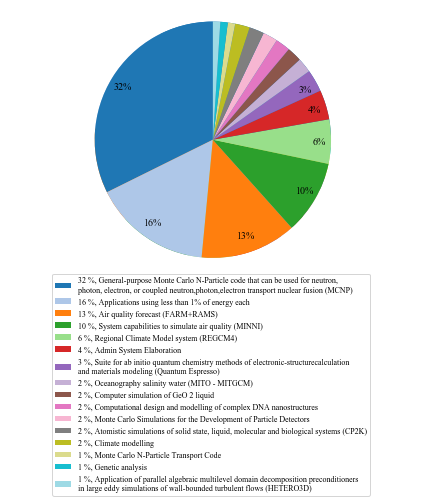

In [21]:
scope_clice = lsf_df_consolid_scope[(lsf_df_consolid_scope.energy_percentage>=0.5)]# & \
#                                     (lsf_df_consolid_scope.application_performed_and_scope.str.count('\/')<=1) ]
                                 
# labels = scope_clice.application_performed_and_scope

cmap = plt.cm.tab20
colors = cmap(np.linspace(0., 1., scope_clice.shape[0]))


fracs = scope_clice.energy_percentage.apply( lambda x: int(round(x,0)) )
labels = ['%1.0f %%, %s' % (s, l) for s, l in zip(fracs,scope_clice.application_performed_and_scope)]
plt.pie(fracs, radius=20, colors=colors)
patches, texts, autotexts  = plt.pie(fracs, radius=20, startangle=90, autopct='%.f%%', colors=colors)

for patch, txt in zip(patches, autotexts):
    # the angle at which the text is located
    ang = (patch.theta2 + patch.theta1) / 2.
    # new coordinates of the text, 0.7 is the distance from the center 
    x = patch.r * 0.9 * np.cos(ang*np.pi/180)
    y = patch.r * 0.85 * np.sin(ang*np.pi/180)
    # if patch is narrow enough, move text to new coordinates
    
    if (patch.theta2 - patch.theta1) < 10.:
        txt.remove()
    else:
        txt.set_position((x,y))


plt.axis('equal')
plt.legend(patches, labels, bbox_to_anchor=(0.9, 0),prop={'size': 8})
# plt.legend( patches, loc = 'right', labels=['%1.0f %%, %s' % (s, l) for s, l in zip(fracs,labels)])#, bbox_to_anchor=(0.5, -0.3
plt.tight_layout()
plt.savefig(os.path.join(Working_dir, 'energy_cons_scope_1200.png'), bbox_inches='tight', dpi=1200)
plt.show()

### Categories (scope) of energy waste


In [18]:
lsf_df_consolid_scope.sort_values('energy_exit_percentage', ascending=False)

,application_performed_and_scope,energy_done_kWh,energy_exit_kWh,energy_kWh,energy_percentage,energy_exit_percentage
8,General-purpose Monte Carlo N-Particle code th...,79609.059588,26285.984805,105895.044393,31.692712,7.866980
3,Applications using less than 1% of energy each,35537.771491,18108.547038,53646.318529,16.055495,5.419602
0,Admin System Elaboration,4127.757389,7792.408357,11920.165746,3.567517,2.332145
1,Air quality forecast (FARM+RAMS),37625.754129,4701.737231,42327.491360,12.667949,1.407156
12,Oceanography salinity water (MITO - MITGCM),4032.815931,3956.907149,7989.723080,2.391198,1.184240
15,System capabilities to simulate air quality (M...,30215.949465,3639.558298,33855.507763,10.132418,1.089262
7,Computer simulation of GeO 2 liquid,4740.260993,2910.180569,7650.441562,2.289656,0.870971
4,"Atomistic simulations of solid state, liquid, ...",3641.689857,2403.046283,6044.736140,1.809094,0.719194
5,Climate modelling,4507.590662,1390.477236,5898.067898,1.765198,0.416148
13,Regional Climate Model system (REGCM4),19771.440281,1269.391936,21040.832218,6.297188,0.379909


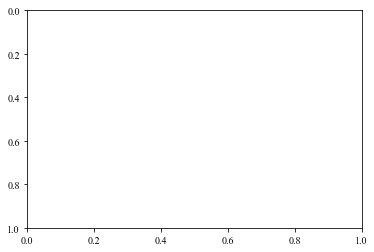

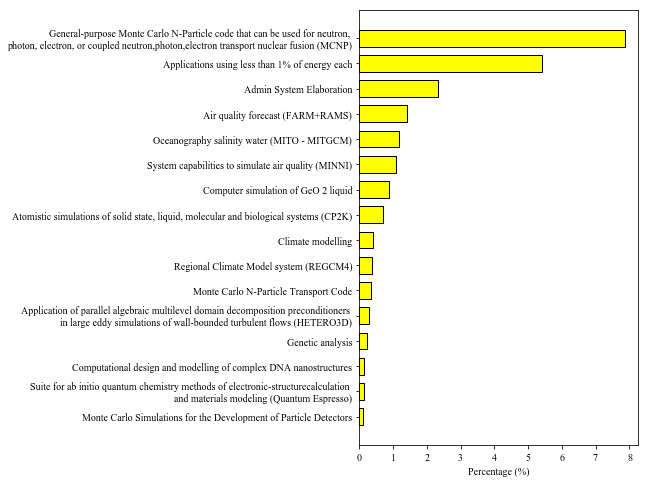

In [11]:
s=lsf_df_consolid_scope.energy_exit_percentage.sort_values(ascending=True)
s.index=lsf_df_consolid_scope.sort_values('energy_exit_percentage', ascending=True).application_performed_and_scope
fig, ax = plt.subplots()
plt.figure(figsize=(5,8))

cmap = plt.cm.tab20
colors = cmap(np.linspace(0., 1., len(s)))

N = 11
ind = np.arange(lsf_df_consolid_scope.shape[0]) *1.5   # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

fig = plt.barh(ind, s,edgecolor='black', height=1, color='yellow')#en_exit_jobs_kWh, color='yellow',
ax.invert_yaxis()
plt.xlabel('Percentage (%)')
plt.yticks(ind, (s.index))

plt.savefig(os.path.join(Working_dir, 'ewr-percentage.png'),\
            bbox_inches='tight', \
            dpi=1200)
plt.show()

#### Ideas on grouping more elements into scopes

In [221]:
lsf_df_consolid_scope_names = lsf_df_consolid_scope.\
     application_performed_and_scope.\
     str.extractall('(^/gporq2/scratch_0/usr/wangt/.*)').iloc[:,0]
folder_list = []
for i in range(lsf_df_consolid_scope_names.shape[0]):
    folder_name = lsf_df_consolid_scope_names.str.split('/')[i]
    if (len(folder_name)>5):
        folder_name=folder_name[5]
        if not(folder_name in folder_list):
            folder_list.append(folder_name)

folder_list

['2017_new', 'antenna']

----
### Analysing results

In [12]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )

s=summary[['en_exit_only_jobs_kWh','en_done_only_jobs_kWh']].copy()
s.iloc[:,0]

1     14918.244962
2     17932.906806
3      8557.787301
4     10430.942884
5     11122.062777
6      6655.135602
7      6579.148326
8     18532.691052
9     17691.216177
10    23459.089116
11    17578.330563
Name: en_exit_only_jobs_kWh, dtype: float64

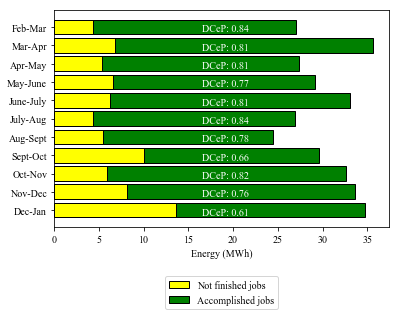

In [18]:
s=summary[['en_exit_jobs_kWh','en_done_jobs_kWh']].copy()
# s=summary[['en_exit_only_jobs_kWh','en_done_only_jobs_kWh']].copy()

s = s/1000

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.barh(ind, s.en_exit_jobs_kWh, color='white', edgecolor='black', hatch='xx')
# p2 = plt.barh( ind, s.en_done_jobs_kWh, color='white', edgecolor='black', left = s.en_exit_jobs_kWh )

p1 = plt.barh(ind, s.iloc[:,0], color='yellow', edgecolor='black')#en_exit_jobs_kWh
p2 = plt.barh( ind, s.iloc[:,1], color='green', edgecolor='black', left = s.iloc[:,0] )
#en_done_jobs_kWh

plt.xlabel('Energy (MWh)')
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))


for i,j in zip(ind, s.iloc[:,0]):#s.en_exit_jobs_kWh
    ax.annotate('DCeP: %.2f'%round(summary.DCeP.iloc[i],2),
                xy=((s.iloc[:, 0].max())+3, i+0.25), size=10, color='white')
#     if i==9:
#         ax.annotate('DCeP: %.2f'%round(summary.DCeP_exit_done_only.iloc[i],2),
#                 xy=((summary.en_exit_only_jobs_kWh.iloc[9]/1000)+0.3, i+0.25), size=10, color='white')
#     else:
#         ax.annotate('DCeP: %.2f'%round(summary.DCeP_exit_done_only.iloc[i],2),
#                 xy=((summary.en_exit_only_jobs_kWh.iloc[7]/1000)+0.4, i+0.25), size=10, color='white') 

ax.invert_yaxis()
lgd = plt.legend((p1[0], p2[0]), ('Not finished jobs', 'Accomplished jobs'),\
#            loc='center center', bbox_to_anchor=(1, 0.6))
             loc='upper center', bbox_to_anchor=(0.5, -0.2))
fig.savefig(os.path.join(Working_dir, 'energy_cons_ex_done_no_title.png'),\
            bbox_extra_artists=(lgd,), bbox_inches='tight', \
            dpi=1200)
plt.show()

---
### Jobs distribution by energy consumption

In [4]:
print(lsf_df.stop_timestamp_py.max())
print(lsf_df.stop_timestamp_py.min())
# Timestamp('2018-01-25 04:12:17')

2018-01-25 04:12:17
2016-12-28 21:12:32


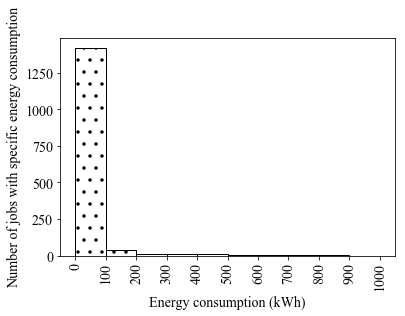

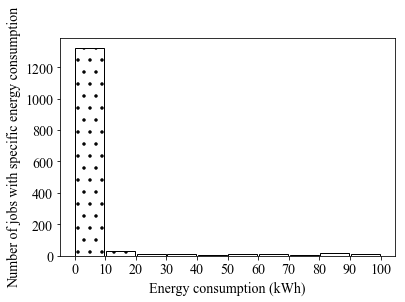

In [341]:
plt.rc('font', family='serif', serif='Times New Roman', size = '14' )

i = 0
left_time_border = datetime.datetime(2017,i+2,19,12,0)
if i>=10:
#     date_new = lsf_df.stop_timestamp_py.max().date()
    date_new = datetime.date(year=2018, month=1, day=25)
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
else:
    right_time_border = datetime.datetime(2017,i+3,19,12,0)
m = 1
    
folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

lsf_done_energy = pd.read_excel(os.path.join( folder_name, 'lsf_done_month_df.xlsx'))
lsf_exit_energy = pd.read_excel(os.path.join( folder_name, 'lsf_exited_month_df.xlsx'))

job_done_energy = lsf_done_energy.energy_done_kWh
job_exit_energy = lsf_exit_energy.energy_exit_kWh

job_all_energy = pd.concat([job_done_energy, job_exit_energy], axis=1)
job_all_energy = job_all_energy.sum(axis=1)

max_en = job_all_energy.values.max()
max_en -= max_en % -100
max_en = int(max_en)
bins = np.array(range(0,max_en,100))
groups = job_all_energy.groupby(pd.cut(job_all_energy,bins))

pos = (range(len(bins)-1))


plt.bar(pos, groups.size(), color='white', width = 1, edgecolor='black', hatch='.')
# plt.bar(pos, groups.size(), color='purple', width = 1, edgecolor='black')

plt.xlabel('Energy consumption (kWh)')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int), rotation=90)

plt.savefig(os.path.join(folder_name, 'en_cons_ranges_no_colour.png'), bbox_inches='tight', dpi=900)
# plt.savefig(os.path.join(folder_name, 'en_cons_ranges.png'), bbox_inches='tight', dpi=900)
plt.show()

max_en = 110
bins = np.array(range(0,max_en,10))
groups = job_all_energy.groupby(pd.cut(job_all_energy,bins))

pos = (range(len(bins)-1))

# plt.bar(pos, groups.size(), color='purple', width = 0.95, edgecolor='black')
plt.bar(pos, groups.size(), color='white', width = 0.95, edgecolor='black', hatch='.')
plt.xlabel('Energy consumption (kWh)')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int))

plt.savefig(os.path.join(folder_name, 'en_cons_ranges_granular_no_colour.png'), bbox_inches='tight', dpi=900)
# plt.savefig(os.path.join(folder_name, 'en_cons_ranges_granular.png'), bbox_inches='tight', dpi=900)
plt.show()

### Check if there is any job which was reported as "done" but exceeded queue max duration time

In [240]:
lsf_df_init = pd.read_excel( os.path.join( Working_dir, "lsf_v3_py.xlsx" ) )
lsf_df_init[((lsf_df_init.job_status=='done')&(lsf_df_init.queue_duration_sec < lsf_df_init.job_duration_sec))]

,row_counter,job_id,number_of_cores_used,user_name,queue_len_hours,queue_name,directory_of_running_executable,name_of_executable,job_status,start_unixtime,stop_unixtime,job_duration_sec,queue_duration_sec,percentage_of_usage_of_queue,residual_time_of_queue,application_performed_and_scope,start_timestamp_py,stop_timestamp_py,executable_full_name


### Visualisation of 10 kWh jobs ratio

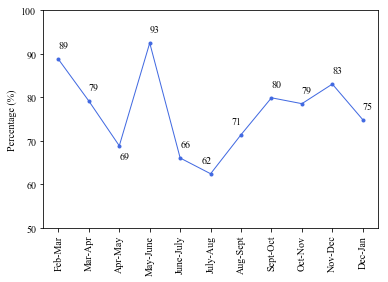

In [14]:
percent = summary.percentage_10_kWh.copy()

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, percent, color='royalblue', linestyle='-', marker='o',linewidth=1, markersize=3)
# p1 = plt.plot(ind, percent, color='k', linestyle='-', marker='o',linewidth=1, markersize=3)

# plt.xlabel('Time interval')
plt.ylabel('Percentage (%)')

# plt.title('Ratio of processes with energy consumption \nwithin 10 kWh range')

plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)
plt.yticks(range(50,110,10))

for i, j in zip(ind, percent):
    if (i==6 or i==5):
        ax.annotate(str(int(round(j))), xy=(i-0.3, j+2), horizontalalignment='left',
            verticalalignment='bottom')
    elif (i==2):
        ax.annotate(str(int(round(j))), xy=(i, j-3.5), horizontalalignment='left',
            verticalalignment='bottom')
    else:
        ax.annotate(str(int(round(j))), xy=(i, j+2), horizontalalignment='left',
            verticalalignment='bottom')

fig.savefig(os.path.join(Working_dir, 'en_cons_less_10_no_title_new.png'), bbox_inches='tight', dpi=1200)
plt.show()

#### Percentage of all reported jobs which had small duration

In [261]:
print('<=30 seconds, percentage related to the number of jobs: ', lsf_df[ lsf_df.job_duration_sec <=30 ].shape[0] / lsf_df.shape[0] * 100, '%')
print('<=50 seconds, percentage related to the number of jobs: ', lsf_df[ lsf_df.job_duration_sec <=50 ].shape[0] / lsf_df.shape[0] * 100, '%')

<=30 seconds, percentage related to the number of jobs:  19.197125132851426 %
<=50 seconds, percentage related to the number of jobs:  26.416516541415724 %


### Visualisation of short jobs analysis

In [7]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )

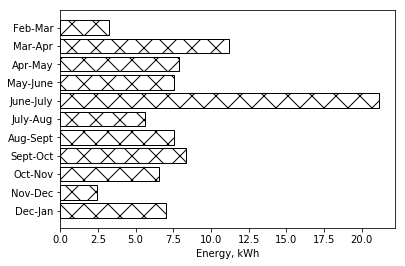

In [49]:
s=summary['en_exit_short_jobs_kWh'].copy()

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, s, color='white', edgecolor='black', hatch='x')
# p1 = plt.barh(ind, s, color='lightseagreen', edgecolor='black')

plt.xlabel('Energy, kWh')
# plt.title('Energy consumption of jobs with maximum running time of 30 sec')
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))
ax.invert_yaxis()

fig.savefig(os.path.join(Working_dir, 'energy_cons_short_jobs_no_title_no_colour.png'), bbox_inches='tight', dpi=900)
# fig.savefig(os.path.join(Working_dir, 'energy_cons_short_jobs_no_title.png'), bbox_inches='tight', dpi=900)
plt.show()

In [124]:
summary.columns.values

array(['month_start', 'month_end', 'en_exit_jobs_kWh',
       'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',
       'en_done_jobs_kWh', 'en_done_long_jobs_kWh', 'en_no_outliers_kWh',
       'en_with_outliers_kWh'], dtype=object)

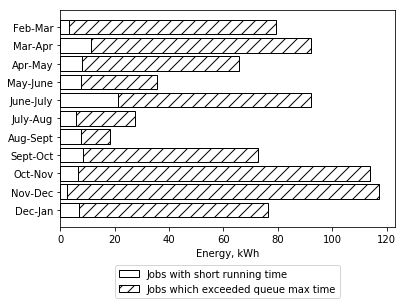

In [18]:
s=summary[['en_exit_short_jobs_kWh', \
           'en_exit_long_jobs_remainder_kWh', \
           'en_exit_jobs_kWh']].copy()

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.barh(ind, s.en_exit_short_jobs_kWh, color='lightseagreen', edgecolor='black')/
p1 = plt.barh(ind, s.en_exit_short_jobs_kWh, color='white', edgecolor='black', hatch='0')

# p2 = plt.barh( ind, s.en_exit_long_jobs_remainder_kWh, color='khaki', edgecolor='black', left = s.en_exit_short_jobs_kWh )
p2 = plt.barh( ind, s.en_exit_long_jobs_remainder_kWh, \
              color='white', edgecolor='black', hatch='//',\
              left = s.en_exit_short_jobs_kWh )
plt.xlabel('Energy, kWh')
# plt.title('Energy waste categories')
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))
ax.invert_yaxis()

lgd = plt.legend((p1[0], p2[0]), ('Jobs with short running time', 'Jobs which exceeded queue max time'),\
           loc='upper center', bbox_to_anchor=(0.5, -0.15))

fig.savefig(os.path.join(Working_dir, 'energy_cons_ex_long_and_short_jobs_no_title_no_colour.png'),\
            bbox_extra_artists=(lgd,), bbox_inches='tight',\
            dpi=900)
plt.show()

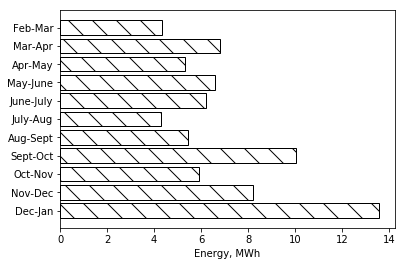

In [64]:
s=summary[['en_exit_jobs_kWh']].copy()

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

# p3 = plt.barh( ind, s.en_exit_jobs_kWh/1000., color='yellowgreen', edgecolor='black')
p3 = plt.barh( ind, s.en_exit_jobs_kWh/1000., color='white', edgecolor='black', hatch='\\')
plt.xlabel('Energy, MWh')
# plt.title('Energy waste category\nJobs not accomplished for other reasons')
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))
ax.invert_yaxis()

fig.savefig(os.path.join(Working_dir, 'energy_cons_exit_only_jobs_no_title_no_colour.png'),\
            bbox_inches='tight',\
            dpi=900)
plt.show()

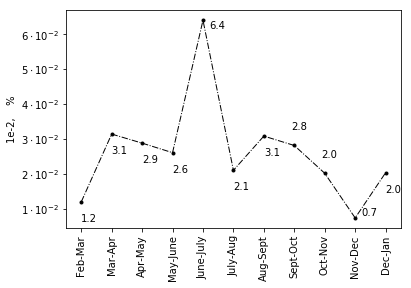

In [256]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, percent_short_jobs, color='k', linestyle='-.', marker='o',\
              markersize=3, linewidth=1)#lightseagreen

# plt.xlabel('Time interval')
# plt.ylabel(r'$\times 10^{-2}$, %')
plt.ylabel(r'1e-2,    %')

import matplotlib.ticker as ticker
def myticks(x,pos):

    if x == 0: return "$0$"

    coeff = round(x*100.,1)
    return r"${:2.0f} \cdot 10^{{ {:2d} }}$".format(coeff,-2)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(myticks))
# plt.yscale('log')

for i, j in zip(ind, percent_short_jobs):
    if (i==4):
        j_pos=j-0.003
        i_pos=i+0.2
    elif (i==9):
        j_pos=j
        i_pos=i+0.2
    elif (i==8 or i==7):
        j_pos=j+0.004
        i_pos=i-0.1
    else:
        j_pos=j-0.0062
        i_pos=i
    ax.annotate(str(round(j*100, 1)), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')

# plt.title('Ratio of energy consumed by jobs with short running time\nwith relation to overall energy consumtpion')

plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)

fig.savefig(os.path.join(Working_dir, 'en_cons_short_jobs_energy_percent_no_title_no_colour.png'), bbox_inches='tight',\
           dpi=900)
plt.show()

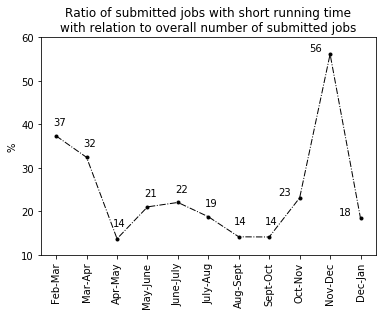

In [259]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, summary.percentage_short_jobs, color='k', linestyle='-.', marker='o',\
              markersize=3, linewidth=1)#color='lightseagreen'

# plt.xlabel('Time interval')
plt.ylabel('%')

for i, j in zip(ind, summary.percentage_short_jobs):
    if (i>=8):
        j_pos=j+0.2
        i_pos=i-0.7
    elif (i in [2,6,7]):
        i_pos=i-0.15
        j_pos=j+2.5
    else:
        j_pos=j+2
        i_pos=i-0.1
    ax.annotate(str(int(round(j))), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')

plt.title('Ratio of submitted jobs with short running time\nwith relation to overall number of submitted jobs')
plt.yticks(range(10,65,10))
plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)

fig.savefig(os.path.join(Working_dir, 'number_percent_short_jobs_no_colour.png'), bbox_inches='tight',\
           dpi=900)
plt.show()

---

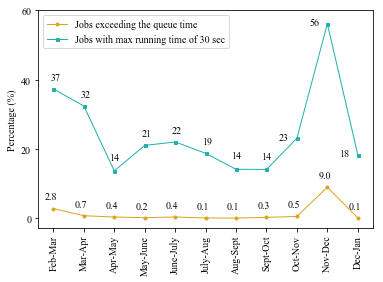

In [15]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, summary.percentage_long_jobs, color='goldenrod', \
              linestyle='-', marker='o',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle=':'

p2 = plt.plot(ind, summary.percentage_short_jobs, color='lightseagreen', \
              linestyle='-', marker='s',\
              markersize=3, linewidth=1)#color='lightseagreen''k',linestyle='-.'

# plt.xlabel('Time interval')
plt.ylabel('Percentage (%)')

for i, j in zip(ind, summary.percentage_short_jobs):
    if (i>=8):
        j_pos=j-1
        i_pos=i-0.6
    elif (i in [2,6,7]):
        i_pos=i-0.15
        j_pos=j+2.5
    else:
        j_pos=j+2
        i_pos=i-0.1
    ax.annotate(str(int(round(j))), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')

for i, j in zip(ind, summary.percentage_long_jobs):
    j_pos=j+2
    i_pos=i-0.3
    ax.annotate(str(round(j,1)), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')
    
# plt.title('Ratio of submitted jobs with short running time\nor exceeding the queue time\nwith relation to overall number of submitted jobs')
plt.yticks(range(0,67,20))

lgd = plt.legend((p1[0], p2[0]), ( 'Jobs exceeding the queue time', 'Jobs with max running time of 30 sec' ),\
           loc='upper left')#, bbox_to_anchor=(0.5, -0.3))
plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)

fig.savefig(os.path.join(Working_dir, 'number_percent_short_long_jobs_no_title_new.png'), bbox_inches='tight',\
           dpi=1200)
plt.show()

----

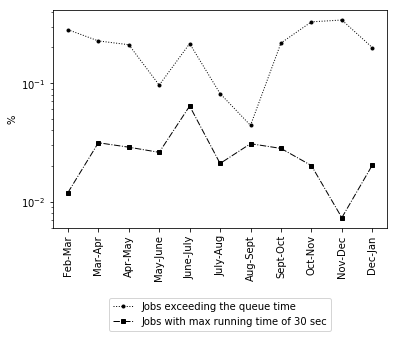

In [262]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, percent_long_jobs, color='k', linestyle=':', marker='o', markersize=3, linewidth=1)#lightseagreen
p2 = plt.plot(ind, percent_short_jobs, color='k', linestyle='-.', marker='s', markersize=3.5, linewidth=1)#lightseagreen
plt.ylabel('%')
ax.semilogy()

# plt.title('Ratio of energy consumed by jobs with running time\nexceeding max queue time\nand short duration jobs')
plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)
lgd = plt.legend((p1[0], p2[0]), ( 'Jobs exceeding the queue time', 'Jobs with max running time of 30 sec' ),\
           loc='upper center', bbox_to_anchor=(0.5, -0.3))
fig.savefig(os.path.join(Working_dir, 'en_cons_short_long_jobs_energy_percent_no_title_no_colour_logy.png'), \
            bbox_inches='tight' ,\
           dpi=900)
plt.show()

---

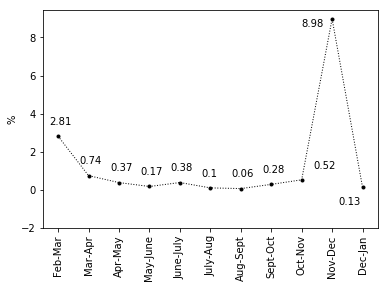

In [280]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, summary.percentage_long_jobs, color='k', \
              linestyle=':', marker='o',\
              markersize=3, linewidth=1)#color='lightseagreen'

plt.ylabel('%')

for i, j in zip(ind, summary.percentage_long_jobs):
    j_pos=j+0.5
    i_pos=i-0.3
    if (i==9):
        j_pos=j-0.5
        i_pos=i-1
    elif (i==8):
        i_pos=i+0.4
    elif (i==10):
        j_pos=j-1
        i_pos=i-0.8
    ax.annotate(str(round(j,2)), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')
    
# plt.title('Ratio of submitted jobs with running time\nexceeding the queue time\nwith relation to overall number of submitted jobs')
plt.yticks(range(-2,10,2))

plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)

fig.savefig(os.path.join(Working_dir, 'number_percent_long_jobs_no_title_no_colour.png'), bbox_inches='tight',\
           dpi=900)
plt.show()

---

In [360]:
summary_brief = pd.DataFrame(columns=[r'$\leq 30 $ sec', '$>$ queue time', 'other reasons'], \
                             index=['Min','Max','Mean','Variance'])

summary_brief.iloc[0, 0] = summary.percentage_energy_short_jobs.min()
summary_brief.iloc[1, 0] = summary.percentage_energy_short_jobs.max()
summary_brief.iloc[2, 0] = np.mean(summary.percentage_energy_short_jobs.as_matrix())
summary_brief.iloc[3, 0] = np.std(summary.percentage_energy_short_jobs.as_matrix())

summary_brief.iloc[0, 1] = summary.percentage_energy_long_jobs.min()
summary_brief.iloc[1, 1] = summary.percentage_energy_long_jobs.max()
summary_brief.iloc[2, 1] = np.mean(summary.percentage_energy_long_jobs.as_matrix())
summary_brief.iloc[3, 1] = np.std(summary.percentage_energy_long_jobs.as_matrix())

summary_brief.iloc[0, 2] = summary.percentage_energy_exit_jobs.min()
summary_brief.iloc[1, 2] = summary.percentage_energy_exit_jobs.max()
summary_brief.iloc[2, 2] = np.mean(summary.percentage_energy_exit_jobs.as_matrix())
summary_brief.iloc[3, 2] = np.std(summary.percentage_energy_exit_jobs.as_matrix())

write_to_excel(summary_brief, os.path.join( Working_dir, 'energy_percentage_summary_brief.xlsx') )

summary_brief

,$\leq 30 $ sec,$>$ queue time,other reasons
Min,0.00731649,0.0439934,15.982
Max,0.0640729,0.340865,39.0777
Mean,0.0263516,0.204114,22.6736
Variance,0.013988,0.0922504,7.04565


----
## EWR for queues and serial vs // jobs

In [22]:
queues_duration = lsf_df.groupby( 'queue_name', as_index=False )['job_duration_sec'].sum()
queues_duration.loc[:,'job_duration_min'] = queues_duration.job_duration_sec /60.
queues_duration.loc[:,'job_duration_hour'] = queues_duration.job_duration_sec /3600.
write_to_excel( queues_duration.sort_values('job_duration_sec', ascending=False), \
               os.path.join( Working_dir, 'queues_duration.xlsx') )

In [25]:
queues_duration.sort_values('job_duration_hour')

,queue_name,job_duration_sec,job_duration_min,job_duration_hour
10,fsn3_24h24,1.731400e+04,2.885667e+02,4.809444
0,chimere,1.466980e+05,2.444967e+03,40.749444
15,small_10m,3.116350e+05,5.193917e+03,86.565279
13,hpc_ha_h3,4.399830e+05,7.333050e+03,122.217500
3,cpu_plus,6.327480e+05,1.054580e+04,175.763333
1,clima,7.586460e+05,1.264410e+04,210.735000
2,combustione4,9.912330e+05,1.652055e+04,275.342500
11,fsn4_16h24,1.413074e+06,2.355123e+04,392.520556
4,cresco4_16h24,2.225722e+07,3.709536e+05,6182.560000
8,cresco4minni_16h24,2.363440e+07,3.939067e+05,6565.112222


### Is there -> correspondence between app name and queue or between app name and mode of execution (serial/parallel)

If app name a, then queue name b

a->b

or not?

In [58]:
app_queue_groups = pd.DataFrame(lsf_df.groupby(['application_performed_and_scope', 'queue_name']).size())

In [59]:
app_queue_groups.head()

0
application_performed_and_scope                    queue_name      
 ANSYS FLUENT software is used to design produc... cpu_plus      22
                                                   cresco4_h144  26
                                                   cresco4_h6    28
                                                   small_10m     10
 CHIMERE chemistry-transport model is dedicated... chimere        5

---------
#### Answer: NO
- Applications from one scope have been run on different queues
- Therefore, impossible to determine whether app was serial or parallel (?)

In [71]:
app_queue_scope_groups = pd.DataFrame(lsf_df.groupby(['queue_name','application_performed_and_scope']).size())
app_queue_scope_groups.reset_index(inplace=True)
app_queue_scope_groups.set_index('application_performed_and_scope', inplace=True, drop=False)
app_queue_scope_groups = rename_all(app_queue_scope_groups)
app_queue_scope_groups.rename(index=str, columns={0: 'no_of_submitted_jobs'}, inplace=True)

In [74]:
app_queue_scope_groups = pd.DataFrame(app_queue_scope_groups.\
                                      groupby(['queue_name','application_performed_and_scope'])['no_of_submitted_jobs'].sum())
write_to_excel( app_queue_scope_groups, os.path.join( Working_dir, 'queue_app_scope_groups.xlsx')  )

-------------
## EWR - queues

In [26]:
queue_summary_global = pd.DataFrame(columns=['en_exit_jobs_kWh', \
                                'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
                                'en_done_jobs_kWh','en_done_long_jobs_kWh'], index=lsf_df.queue_name.unique())
queue_summary_global[:]=0

In [84]:
i = 9
left_time_border = datetime.datetime(2017,i+2,19,12,0)
if i>=10:
#     date_new = lsf_df.stop_timestamp_py.max().date()
    date_new = datetime.date(year=2018, month=1, day=25)
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
else:
    right_time_border = datetime.datetime(2017,i+3,19,12,0)

print(i)

i=i+1
# open folder and read preprocessed zabbix and lsf data for one month
folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )

# create a dictionary of dataframes 
# each dataframe is named as in proc_df_names
# each dataframe is a matrix of coefficients 
# w_ij = sum_k (duration of job k on queue i in sec duing hour j) / 
#        /3600 * (number of cores required for job k on queue i completion)
proc_df_dict = {}
proc_df_names = ['proc_df_exit', 'proc_df_exit_short', 'proc_df_exit_long', 'proc_df_done', 'proc_df_done_long']
job_status_list = [ 'exit', 'exit_short_30_sec', 'exit_long', 'done', 'done_long' ]
for name, status in zip(proc_df_names, job_status_list):
    proc_df_dict[name] = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, 
                                                  job_status=status, category='queue' )

# create a dictionary of dataframes
# each dataframe is named as in queue_df_names
# each dataframe has queue names as index
# queue names (or indices) are chosen according to the status of jobs
# each dataframe contains data about one current month only
# e.g.1: queue_exited_month_df = dataframe where indices are such queue names,
# the jobs on which exited with either "exit", "exit_short_30_sec" or "exit_long"
# e.g.2: queue_exit_short_month_df = dataframe where indices are such queue names,
# the jobs on which exited with "exit_short_30_sec" only
# so far these dataframes have one column apart from index which is qn_col or "queue_name"
queue_df_dict = {}
queue_df_names = ['queue_exited_month_df', 'queue_exit_short_month_df', 'queue_exit_long_month_df', 
                  'queue_done_month_df', 'queue_done_long_month_df']
qn_col = 'queue_name'
for df_name, status in zip(queue_df_names, job_status_list):
    queue_df_dict[df_name] = pd.DataFrame( slice_month_df( lsf_month_df, job_status=status )[qn_col].\
                                          drop_duplicates()).set_index(qn_col, drop=False)

# working with zabbix 
# z = array of values representing hourly energy use excluding outliers
# values correspongin to outliers in z = 0
z = zabbix_month_df.estimated_en_use_no_outliers.fillna(0).as_matrix()
if z.sum()==0:
    z = zabbix_month_df.estimated_en_use.fillna(0).as_matrix()
    
# for all types of dataframes formed by process_matrix_one_month function (proc_df)
# for all queue names active during this month from lsf,
# i.e. for all columns of proc_df
# convert proc_df from coefficients matrix to matrix showing 
# what amount of energy was used by every queue (column) in every hour (row)
# by multiplying each column of proc_df (coeficients=portions) and z (energy)
for proc_df_name in proc_df_names:
    for q_name in lsf_month_df[qn_col].unique():
        proc_df_dict[proc_df_name].loc[:,q_name] = proc_df_dict[proc_df_name].loc[:, q_name].as_matrix()*z/1000.
    
# add corresponding columns to queue dataframes
# one queue dataframe will get one new corresponding column
queue_df_col_names = ['energy_exit_kWh', 'energy_exit_short_kWh', 'energy_exit_long_kWh', 
                      'energy_done_kWh', 'energy_done_long_kWh']
# each column corresponds to a type of job status
# each row = each index = name of a queue
# to get overall energy value for a queue, 
# we sum energy values from proc_df for a column corresponding to the queue name (qn_col) over all hours
for q_df_name, col_name, proc_df_name in zip( queue_df_names, queue_df_col_names, proc_df_names ):
    queue_df_dict[df_name][col_name] = proc_df_dict[proc_df_name][ queue_df_dict[df_name][qn_col] ].sum(axis=0)
    
# create summary dataframe for all queues for one current month
# each row = each index = name of a queue
# previous queue dataframes contained only some queue names of all queue names from lsf
# since we chose them according to job status type
# (a queue can have jobs with some job status types, maybe not all of them)
queue_summary = pd.DataFrame(columns=['en_exit_jobs_kWh', \
                                'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
                                'en_done_jobs_kWh','en_done_long_jobs_kWh'], index=lsf_df[qn_col].unique())
queue_summary[:]=0
for q_df_name, col_name, proc_df_name in zip( queue_df_names, queue_summary.columns.values, proc_df_names ):
    queue_summary[col_name] = proc_df_dict[proc_df_name][queue_df_dict[q_df_name][qn_col]].sum(axis=0)
queue_summary.fillna(0, inplace=True)

# queue_summary_global - dataframe with aggregated data for all months
queue_summary_global = queue_summary_global + queue_summary

# write dataframes for current month
write_to_excel( queue_summary, os.path.join( folder_name, 'queue_summary_month_df_v2.xlsx') )
for q_df_name in queue_df_names:
    write_to_excel( queue_df_dict[q_df_name], os.path.join( folder_name, q_df_name + '.xlsx') )

print('One line added to summary')

10
Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

en_exit_jobs_kWh                   13567.856492
en_exit_short_jobs_kWh                 7.046068
en_exit_long_jobs_remainder_kWh       69.327294
en_done_jobs_kWh                   21152.379241
en_done_long_jobs_kWh               4010.474071
dtype: float64
One line added to summary


In [106]:
queue_summary_global.loc[:,'EWR_percentage'] = queue_summary_global.en_exit_jobs_kWh/\
(queue_summary_global.en_exit_jobs_kWh + queue_summary_global.en_done_jobs_kWh)*100

queue_summary_global.loc[:, 'energy_kWh'] = queue_summary_global.en_done_jobs_kWh + queue_summary_global.en_exit_jobs_kWh

queue_summary_global.loc[:, 'no_of_submitted_jobs'] = lsf_df.groupby( 'queue_name', as_index=True )['job_id'].count().values

write_to_excel( queue_summary_global.sort_values('energy_kWh', ascending=False), \
               os.path.join( Working_dir, 'queue_summary_global_q.xlsx') )

# summary_q = summary.copy()
# write_to_excel( summary_q, os.path.join( Working_dir, 'energy_summary_q.xlsx') )

In [138]:
queue_summary_global.EWR_percentage.mean()

32.493977729940234

In [142]:
queue_summary_global.energy_kWh[:-4].sum()/queue_summary_global.energy_kWh.sum()*100

99.99616542577523

In [143]:
queue_summary_global.no_of_submitted_jobs[:-4].sum()

50660

In [144]:
queue_summary_global.no_of_submitted_jobs[:-4].sum()/queue_summary_global.no_of_submitted_jobs.sum()*100

9.546458425983854

In [145]:
queue_summary_global.no_of_submitted_jobs[-4:].sum()/queue_summary_global.no_of_submitted_jobs.sum()*100

90.45354157401616

-----

#### Check that "chimere" queue does not have any kind of "done" jobs

In [25]:
lsf_df.job_status.loc[lsf_df.queue_name=='chimere'].unique()

array(['exit_short_30_sec', 'EXIT'], dtype=object)

#### What apps were run on "chimere"

In [26]:
print(lsf_df.application_performed_and_scope.loc[lsf_df.queue_name=='chimere'].unique())

[ ' CHIMERE chemistry-transport model is dedicated to regional atmospheric pollution event'
 'WEATHER RESEARCH AND FORECASTING MODEL']


### Graph of queues EWR

In [11]:
queue_summary_global = pd.read_excel(os.path.join( Working_dir, 'queue_summary_global_q.xlsx'))

In [12]:
# queue_summary_global.energy_kWh[:-4].sum()/queue_summary_global.energy_kWh.sum()*100

In [13]:
# queue_summary_global.energy_kWh[:14].sum()/queue_summary_global.energy_kWh.sum()*100

In [14]:
# queue_summary_global.EWR_percentage[:14].mean()

In [32]:
s = queue_summary_global.energy_kWh
s.index = range(1, len(s)+1)


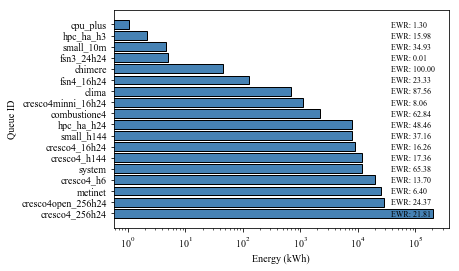

In [42]:
s = queue_summary_global.energy_kWh
ewr = queue_summary_global.EWR_percentage
fig, ax = plt.subplots()
N = np.arange(s.shape[0])
ind = np.arange(s.shape[0])    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, s, color='steelblue', edgecolor='black')
# p1 = plt.bar(ind, s, color='white', edgecolor='black', hatch='\\',)
# p1 = plt.barh(ind, s, color='silver', edgecolor='black',)

ax.set_xscale('log')

plt.ylabel('Queue ID')
plt.xlabel('Energy (kWh)')
plt.yticks(ind, s.index, rotation=0 )
for i,j in zip(ind, s):#s.en_exit_jobs_kWh
    ax.annotate('EWR: %.2f'%round(ewr.iloc[i],2),
                xy=(s.iloc[1]+10000, i-0.25), size=8, color='k')
#     ax.axhline(i,format(s[i],'1.0e'),0.825, color='k', lw=0.5, ls=':')
#     print(base(format(s[i],'1.0e')))

fig.savefig(os.path.join(Working_dir, 'queue_en_cons_and_ewr_no_title_v2_queue_name.png'), bbox_inches='tight', dpi=1200)
plt.show()

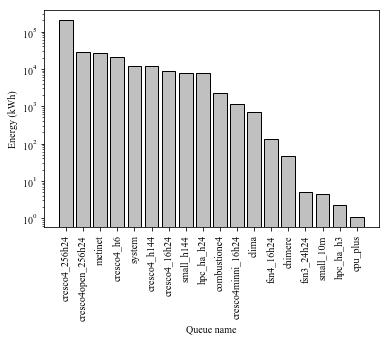

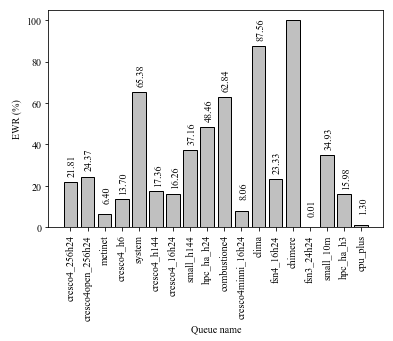

In [52]:
queue_summary_global = pd.read_excel( os.path.join( Working_dir, 'queue_summary_global_q.xlsx') )
s=queue_summary_global.energy_kWh
fig, ax = plt.subplots()
N = np.arange(s.shape[0])
ind = np.arange(s.shape[0])    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, s, color='lightseagreen', edgecolor='black')
# p1 = plt.bar(ind, s, color='white', edgecolor='black', hatch='\\',)
p1 = plt.barh(ind, s, color='silver', edgecolor='black',)

ax.set_yscale('log')

plt.xlabel('Queue name')
plt.ylabel('Energy (kWh)')
plt.xticks(ind, s.index, rotation='vertical' )

fig.savefig(os.path.join(Working_dir, 'queue_en_cons_no_title_no_colour_v2.png'), bbox_inches='tight', dpi=1200)
plt.show()




s=queue_summary_global['EWR_percentage'].copy()
fig, ax = plt.subplots()
N = np.arange(s.shape[0])
ind = np.arange(s.shape[0])    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, s, color='lemonchiffon', edgecolor='black')
# p1 = plt.bar(ind, s, color='white', edgecolor='black', hatch='///')
p1 = plt.bar(ind, s, color='silver', edgecolor='black',)


plt.xlabel('Queue name')
plt.ylabel('EWR (%)')
plt.xticks(ind, s.index, rotation='vertical' )

for (i, j) in zip(ind, s):
    ax.annotate('%.2f'%round(queue_summary_global.EWR_percentage.iloc[i],2),
                xy=( i-0.2, j+10, ), size=10, color='black', rotation='vertical')

fig.savefig(os.path.join(Working_dir, 'queue_ewr_no_title_v2.png'), bbox_inches='tight', dpi=1200)
plt.show()

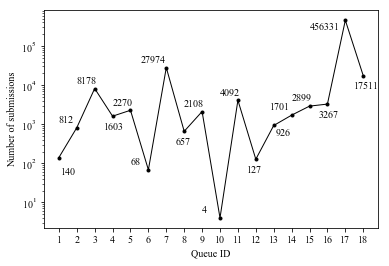

In [41]:
queue_summary_global = pd.read_excel( os.path.join( Working_dir, "queue_summary_global_q.xlsx" ) )
s = queue_summary_global.no_of_submitted_jobs.copy()
s.index = range(1, len(s)+1, 1)
fig, ax = plt.subplots()

N = s.shape[0]
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.plot(ind, s, color='royalblue', linestyle='-', marker='o',linewidth=1, markersize=3, )
p1 = plt.plot(ind, s, color='k', linestyle='-', marker='o',linewidth=1, markersize=3)
plt.xticks(ind, s.index )

# plt.xlabel('Queue name')
plt.xlabel('Queue ID')
plt.ylabel('Number of submissions')

ax.set_yscale('log')

for i, j in zip(ind, s):
    j_pos=j*1.2
    i_pos=i-1
    if (i==3 or i==7 or i==11 or i==15 or i==17):
        j_pos=j/2.5
        i_pos=i-0.5
    elif (i==0):
        j_pos=j/3
        i_pos=i+0.1
    elif (i==6):
        j_pos=j*1.2
        i_pos=i-1.4
    elif (i==12):
        j_pos=j/2
        i_pos=i+0.1
    elif (i==13):
        i_pos=i-1.2
    elif (i==16):
        j_pos=j/2
        i_pos=i-2
    ax.annotate(str(int(round(j))), xy=(i_pos, j_pos), horizontalalignment='left',
        verticalalignment='bottom')
fig.savefig(os.path.join(Working_dir, 'no_of_jobs_per_queue_v2_id.png'), bbox_inches='tight', dpi=1200)
plt.show()

-----
### Carbon factors - calculation of CO2e caused by electricity use by the cluster

Carbon factor for Italy: 0.343 tCO2/MWh, as of 2013 (latest available)

Source: Koffi B, Cerutti A.K., Duerr M., Iancu A., Kona A., Janssens-Maenhout G., Covenant of Mayors for Climate and Energy: Default emission factors for local emission inventories– Version 2017, EUR 28718 EN, Publications Office of the European Union, Luxembourg, 2017, ISBN 978-92-79-71479-5, doi:10.2760/290197, JRC107518.

In [266]:
cf = 0.343

summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )
summary.loc[:,'CO2e_all_jobs_t'] = cf *  summary.en_no_outliers_kWh/1000.
summary.loc[:,'CO2e_exit_jobs_t'] = cf *  summary.en_exit_jobs_kWh/1000.
write_to_excel( summary, os.path.join( Working_dir, "energy_summary.xlsx" ) )
summary

,month_start,month_end,en_exit_jobs_kWh,en_exit_short_jobs_kWh,en_exit_long_jobs_remainder_kWh,en_done_jobs_kWh,en_done_long_jobs_kWh,en_no_outliers_kWh,en_with_outliers_kWh,percentage_10_kWh,...,percentage_exit_jobs,percentage_energy_long_jobs,percentage_energy_short_jobs,percentage_energy_exit_jobs,DCeP,en_exit_only_jobs_kWh,en_done_only_jobs_kWh,DCeP_exit_done_only,CO2e_all_jobs_t,CO2e_exit_jobs_t
1,2017-02-19 12:00:00,2017-03-19 12:00:00,4317.861826,3.215989,76.271213,22686.567603,10600.383136,27004.429429,31140.764417,88.756614,...,51.729201,0.282440,0.011909,15.989458,0.840105,14918.244962,12086.184467,0.447563,9.262519,1.481027
2,2017-03-19 12:00:00,2017-04-19 12:00:00,6805.040174,11.187131,80.917532,28834.552185,11127.866632,35639.592358,35675.376358,79.153094,...,61.170194,0.227044,0.031390,19.094046,0.809060,17932.906806,17706.685553,0.496826,12.224380,2.334129
3,2017-04-19 12:00:00,2017-05-19 12:00:00,5313.371848,7.888162,57.776055,22084.567869,3244.415453,27397.939717,33283.833554,68.852459,...,89.263473,0.210877,0.028791,19.393326,0.806067,8557.787301,18840.152416,0.687649,9.397493,1.822487
4,2017-05-19 12:00:00,2017-06-19 12:00:00,6600.795179,7.581142,28.004482,22505.563546,3830.147705,29106.358725,33873.466033,92.505656,...,80.827787,0.096214,0.026046,22.678189,0.773218,10430.942884,18675.415841,0.641627,9.983481,2.264073
5,2017-06-19 12:00:00,2017-07-19 12:00:00,6187.592266,21.156559,71.184893,26831.909609,4934.470511,33019.501875,33019.501875,66.051661,...,81.017748,0.215584,0.064073,18.739205,0.812608,11122.062777,21897.439098,0.663167,11.325689,2.122344
6,2017-07-19 12:00:00,2017-08-19 12:00:00,4297.479005,5.642735,21.944220,22591.933966,2357.656597,26889.412971,31069.230888,62.430168,...,40.798179,0.081609,0.020985,15.982048,0.840180,6655.135602,20234.277369,0.752500,9.223069,1.474035
7,2017-08-19 12:00:00,2017-09-19 12:00:00,5430.065042,7.542355,10.769712,19050.219062,1149.083284,24480.284104,28867.394600,71.409029,...,14.536414,0.043993,0.030810,22.181381,0.778186,6579.148326,17901.135778,0.731247,8.396737,1.862512
8,2017-09-19 12:00:00,2017-10-19 12:00:00,10017.930231,8.323274,64.559927,19587.892852,8514.760821,29605.823083,34958.687683,79.895561,...,17.970504,0.218065,0.028114,33.837702,0.661623,18532.691052,11073.132031,0.374019,10.154797,3.436150
9,2017-10-19 12:00:00,2017-11-19 12:00:00,5902.938805,6.564893,107.208318,26693.739570,11788.277372,32596.678375,37476.907925,78.544061,...,25.099041,0.328893,0.020140,18.109019,0.818910,17691.216177,14905.462198,0.457269,11.180661,2.024708
10,2017-11-19 12:00:00,2017-12-19 12:00:00,8191.315390,2.463487,114.770286,25479.010968,15267.773726,33670.326358,38492.510329,83.047945,...,77.277599,0.340865,0.007316,24.327995,0.756720,23459.089116,10211.237242,0.303271,11.548922,2.809621


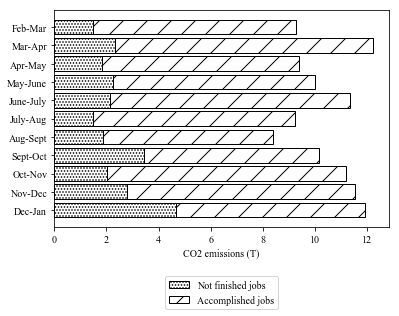

In [54]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )
s=summary[['CO2e_exit_jobs_t','CO2e_all_jobs_t']].copy()

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh( ind, s.iloc[:,0], color='white', edgecolor='black', hatch='....')
p2 = plt.barh( ind, s.iloc[:,1]-s.iloc[:,0], color='white', edgecolor='black', left = s.iloc[:,0], hatch='/' )

# p1 = plt.barh(ind, s.iloc[:,0], color='lightsalmon', edgecolor='black')#en_exit_jobs_kWh
# p2 = plt.barh( ind, s.iloc[:,1]-s.iloc[:,0], color='lightslategrey', edgecolor='black', left = s.iloc[:,0] )
#en_done_jobs_kWh

plt.xlabel('CO2 emissions (T)')
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))


ax.invert_yaxis()
lgd = plt.legend((p1[0], p2[0]), ('Not finished jobs', 'Accomplished jobs'),\
             loc='upper center', bbox_to_anchor=(0.5, -0.2))
fig.savefig(os.path.join(Working_dir, 'co2e_ex_done_no_title_no_colour.png'),\
            bbox_extra_artists=(lgd,), bbox_inches='tight', \
            dpi=1200)
plt.show()

## Parallel vs serial jobs energy consumption

Number of jobs that were executed as both parallel and serial

In [156]:
for i in range (1,12):
    left_time_border = datetime.datetime(2017,i+1,19,12,0)
    if i>=11:
    #     date_new = lsf_df.stop_timestamp_py.max().date()
        date_new = datetime.date(year=2018, month=1, day=25)
        right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    else:
        right_time_border = datetime.datetime(2017,i+2,19,12,0)

#     print(i)

    folder_name = Working_dir + "\\"\
              + left_time_border.strftime("%d.%m.%Y %H.%M") \
              + right_time_border.strftime(" - %d.%m.%Y %H.%M")

    zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
    lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )
    lsf_month_df['parallel_serial'] = lsf_month_df['number_of_cores_used'].apply( lambda x: 'serial' if x==1 else 'parallel' )
    parallel_names = set(lsf_month_df[lsf_month_df.parallel_serial=='parallel']['executable_full_name'].unique())
    serial_names = set(lsf_month_df[lsf_month_df.parallel_serial=='serial']['executable_full_name'].unique())
    print('Month ', i, ': ', len(parallel_names.intersection(serial_names)), '\n')

Month  1 :  6 

Month  2 :  26 

Month  3 :  17 

Month  4 :  5 

Month  5 :  11 

Month  6 :  11 

Month  7 :  11 

Month  8 :  5 

Month  9 :  16 

Month  10 :  9 

Month  11 :  4 



In [163]:
parallel_summary_global = pd.DataFrame(columns=['month_start', 'month_end', 'en_exit_jobs_kWh', \
                                'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
                                'en_done_jobs_kWh','en_done_long_jobs_kWh'], index=range(1,12))
parallel_summary_global[:]=1

serial_summary_global = pd.DataFrame(columns=['month_start', 'month_end', 'en_exit_jobs_kWh', \
                                'en_exit_short_jobs_kWh', 'en_exit_long_jobs_remainder_kWh',\
                                'en_done_jobs_kWh','en_done_long_jobs_kWh'], index=range(1,12))
serial_summary_global[:]=0

In [207]:
i=10

left_time_border = datetime.datetime(2017,i+2,19,12,0)
if i>=10:
    date_new = datetime.date(year=2018, month=1, day=25)
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
else:
    right_time_border = datetime.datetime(2017,i+3,19,12,0)

print(i)
i=i+1

folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )

lsf_month_df['parallel_serial'] = lsf_month_df['number_of_cores_used'].apply( lambda x: 'serial' if x==1 else 'parallel' )

proc_df_dict = {}
proc_df_names = ['proc_df_exit', 'proc_df_exit_short', 'proc_df_exit_long', 'proc_df_done', 'proc_df_done_long']
job_status_list = [ 'exit', 'exit_short_30_sec', 'exit_long', 'done', 'done_long' ]

for name, status in zip(proc_df_names, job_status_list):
    proc_df_dict[name] = process_matrix_one_month( zabbix_month_df, lsf_month_df, folder_name, job_status=status, 
                                              category='parallel_serial' )

zabbix_first_line = zabbix_month_df.timestamp_py.iloc[0]
zabbix_last_line = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1]

z = zabbix_month_df.estimated_en_use_no_outliers.fillna(0).as_matrix()
if z.sum()==0:
    z = zabbix_month_df.estimated_en_use.fillna(0).as_matrix()

ps = ['parallel', 'serial']   
for name in proc_df_names:
    for mode in ps:
        proc_df_dict[name].loc[:,mode]       = proc_df_dict[name].loc[:, mode].as_matrix()*z/1000.

tables = [parallel_summary_global, serial_summary_global]    
for table, mode in zip(tables, ps):
    table.loc[i,'month_start'] = left_time_border
    table.loc[i,'month_end']   = right_time_border
    for name, table_col_name in zip(proc_df_names, parallel_summary_global.columns.values[2:]):
        table.loc[i,table_col_name] = proc_df_dict[name][mode].sum(axis=0)
    table.loc[i, 'no_of_submitions'] = lsf_month_df[lsf_month_df.parallel_serial==mode].shape[0]
    table.loc[i, 'no_of_submitted_jobs'] = lsf_month_df[lsf_month_df.parallel_serial==mode].unique().shape[0]
for table in tables:
    table.fillna(0, inplace=True)

print('One line added to summary')

10
Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

Proc matrix finished

One line added to summary


In [217]:
summary = pd.read_excel( os.path.join(Working_dir, 'energy_summary.xlsx'))
tables = [parallel_summary_global, serial_summary_global] 
ps = ['parallel', 'serial']  
for table, mode in zip(tables, ps):
    table['energy_kWh'] = table.en_done_jobs_kWh + table.en_exit_jobs_kWh
    table['EWR']        = table.en_exit_jobs_kWh / summary.en_no_outliers_kWh * 100.
    write_to_excel( table, os.path.join( Working_dir, mode + "_summary_global.xlsx" ) )

In [215]:
np.isclose(serial_summary_global.EWR + parallel_summary_global.EWR, summary.percentage_energy_exit_jobs)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [225]:
tables = [parallel_summary_global, serial_summary_global]    
ps = ['parallel', 'serial']
for i in range (11,12):
    left_time_border = datetime.datetime(2017,i+1,19,12,0)
    if i>10:
        date_new = datetime.date(year=2018, month=1, day=25)
        right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    else:
        right_time_border = datetime.datetime(2017,i+2,19,12,0)
    folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")
    print(i)
    lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )
    lsf_month_df['parallel_serial'] = lsf_month_df['number_of_cores_used'].apply( lambda x: 'serial' if x==1 else 'parallel' )
    for table, mode in zip(tables, ps):
        table.loc[i, 'no_of_submitions'] = lsf_month_df[lsf_month_df.parallel_serial==mode].shape[0]
        table.loc[i, 'no_of_submitted_jobs'] = lsf_month_df[lsf_month_df.parallel_serial==mode]['executable_full_name'].unique().shape[0]
    write_to_excel( lsf_month_df, os.path.join( folder_name, "lsf_month_ps_py.xlsx" ) )

11


In [238]:
for table, mode in zip(tables, ps):
    write_to_excel( table, os.path.join( Working_dir, mode + "_summary_global.xlsx" ) )

### Graphs for parallel vs serial jobs
- EWR
- Submissions
- En consumption

In [10]:
parallel_summary_global = pd.read_excel( os.path.join( Working_dir, "parallel_summary_global.xlsx" )  )
serial_summary_global = pd.read_excel( os.path.join( Working_dir, "serial_summary_global.xlsx" )  )

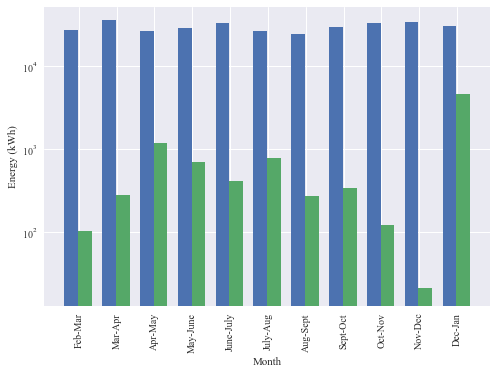

In [76]:
ticks = ['Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan']
df = pd.DataFrame({'Parallel jobs': parallel_summary_global.energy_kWh,
                    'Serial jobs': serial_summary_global.energy_kWh}, )
data = [tuple(x) for x in df.values]

dim = df.shape[0]
w=4
dimw = w/dim

ind = range(dim)
ind = [x+0.2 for x in ind ]

x = np.arange(len(data))
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('Month')
ax.set_ylabel('Energy (kWh)')
plt.yscale('log')
plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)
ax1 = plt.bar
for i in range(len(data[0])):
    y = [d[i] for d in data]
    b = ax.bar(x + i * dimw, y, dimw )
plt.savefig(os.path.join(Working_dir, 'ps_en_cons_log.png'),\
            bbox_inches='tight', \
            dpi=500)
plt.show()
# df

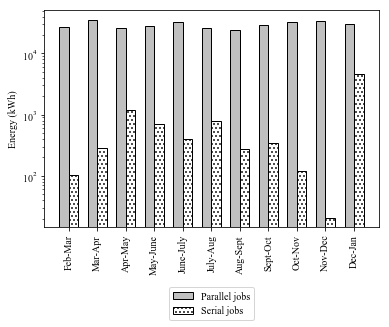

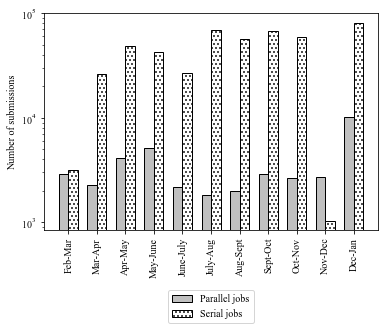

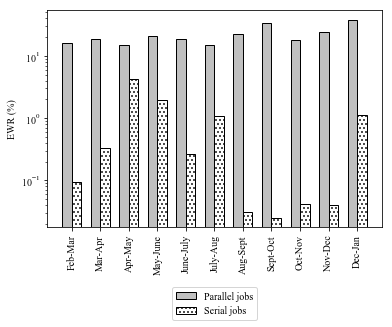

In [56]:
def plot_ps(df, name, ylabel, logscale=True):
    fig, ax = plt.subplots()
    N = 33
    ind1 = np.arange(0,N,3)    # the x locations for the groups
    ind2 = np.arange(1,N,3)
    w = 1      # the width of the bars: can also be len(x) sequence

    p1 = plt.bar( ind1, df.iloc[:,0], color='silver', edgecolor='black', width=w )#
    p2 = plt.bar( ind2, df.iloc[:,1], color='white', edgecolor='black', hatch='...', width=w )

    plt.ylabel(ylabel)
    
    ticks = ['Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan']
    plt.xticks([x+0.5 for x in range(0,33,3)], ticks, rotation=90)
    if logscale:
        plt.yscale('log')
    lgd = plt.legend((p1[0], p2[0]), ('Parallel jobs', 'Serial jobs'), loc='upper center', bbox_to_anchor=(0.5, -0.25))
    fig.savefig(os.path.join(Working_dir, name),\
                bbox_extra_artists=(lgd,), bbox_inches='tight', \
                dpi=1200)
    plt.show()
    
df = pd.DataFrame({'Parallel jobs': parallel_summary_global.energy_kWh,
                    'Serial jobs': serial_summary_global.energy_kWh}, )
plot_ps(df, 'ps_en_cons_log_no_color.png', 'Energy (kWh)')

df = pd.DataFrame({'Parallel jobs': parallel_summary_global.no_of_submitions,
                    'Serial jobs': serial_summary_global.no_of_submitions}, )
plot_ps(df, 'ps_submissions_log_no_color.png', 'Number of submissions')

df = pd.DataFrame({'Parallel jobs': parallel_summary_global.EWR,
                    'Serial jobs': serial_summary_global.EWR}, )
plot_ps(df, 'ps_ewr_log_no_color.png', 'EWR (%)')

In [152]:
parallel_summary_global.EWR.mean()

21.838047774028663

In [153]:
serial_summary_global.EWR.min(), serial_summary_global.EWR.max()

(0.02520910464313399, 4.2279415139716763)